# Experimental design considerations and statistical analyses in preclinical tumor growth inhibition studies - Python tutorial

The goal of this project is to create a comprehensive and accessible Python-based resource for researchers conducting preclinical cancer studies using animal models. We'll adapt the content from the [original R tutorial provided by Bonato and colleagues](https://onlinelibrary.wiley.com/doi/10.1002/pst.2399) to emphasize Python's strengths in data analysis, visualization, and machine learning, offering a modern toolkit for scientists.

## Introduction

**Cancer**, a complex disease driven by the relentless evolution of somatic cells, presents one of the most formidable challenges in modern medicine. This evolution, marked by the accumulation of genetic alterations and the selection of advantageous subclones within a tumor, fundamentally shapes the disease's progression and response to treatment. Understanding this intricate process is not merely a biological curiosity; it is a cornerstone of effective **drug development**.

**Pre-clinical animal models**, serving as invaluable surrogates for human tumors, offer a crucial platform to dissect this evolutionary process and assess the therapeutic potential of novel compounds. By replicating key aspects of tumor growth, heterogeneity, and treatment response, these models enable researchers to identify promising drug targets, optimize dosing regimens, identify biomarkers, evaluate compound safety, and predict clinical outcomes. However, extracting meaningful insights from these studies requires **rigorous statistical analysis** to quantify tumor growth inhibition, assess drug synergy, and discern subtle differences between treatment groups.

This chapter explores the critical intersection of animal models, tumor evolution, and statistical analysis in the quest for effective cancer therapies. We delve into the nuances of study design, endpoint selection, and data analysis techniques tailored for **tumor growth inhibition (TGI)** studies. Our aim is to equip researchers with the knowledge and tools necessary to navigate the complexities of pre-clinical data, ultimately accelerating the translation of promising compounds from the laboratory bench to the patient's bedside.

## Objectives

This tutorial aims to equip researchers with the essential tools for designing and analyzing preclinical animal studies focused on evaluating the efficacy of anticancer drugs. The primary objective is to guide readers in modeling tumor growth dynamics and quantifying tumor growth inhibition (TGI) effects induced by novel compounds compared to control treatments (e.g., placebo or standard therapies).

By the end of this tutorial, we will:
- Understand the fundamental principles of study design for preclinical cancer research, including considerations for animal model selection, treatment allocation, and data collection strategies.
- Gain proficiency in statistical methods for analyzing tumor growth data, both in terms of continuous measures (tumor volume, growth rate) and time-to-event outcomes (survival, tumor progression).
- Interpret and draw conclusions from TGI analyses, assessing the statistical significance and clinical relevance of treatment effects.
- Apply these techniques to real-world data using simulated examples and Python code snippets provided throughout the tutorial.

While no prior experience with Python or R programming is required, a basic understanding of statistical principles (e.g., hypothesis testing, P-values) and familiarity with concepts like linear regression, survival analysis, and non-parametric methods will greatly enhance the learning experience. My [open-source Jupyter Book](https://sbwiecko.github.io/intuitive_biostatistics/README.html), providing a Python-based companion to the "Intuitive Biostatistics" book, might be a valuable resource for this work. We encourage to actively engage with this Jupyter Notebook, adapting them to own datasets to solidify the understanding!

### Toy sample generation

Let's first prepare a function that will generate a **simulated dataset** for a group of animals with specific characteristics.

In [1]:
import numpy as np
import pandas as pd
from scipy.stats import t as t_dist


def simulate_exp_growth(
    group_name: str,
    duration: int,
    initial_tumor_volume: float,
    group_growth_rate_day_pct: float,
    growth_rate_cv: float,
    residual_cv: float,
    n_animals: int,
    max_tumor_volume: float,
    df=None
) -> pd.DataFrame:
    """
    Simulates tumor growth data for a group of animals over a given duration.

    Args:
        group_name (str): Name of the group (e.g., "control", "therapy_a").
        duration (int): Duration of the study in days.
        initial_tumor_volume (float): Initial tumor volume (mm^3).
        group_growth_rate_day_pct (float): Average daily growth rate of the group (%).
        growth_rate_cv (float): Coefficient of variation for the growth rate within the group.
        residual_cv (float): Coefficient of variation for the measurement error.
        n_animals (int): Number of animals in the group.
        max_tumor_volume (float): Maximum allowed tumor volume before removal (mm^3).
        df (int, optional): Degrees of freedom for the t-distribution. If None,
        defaults to n_animals - 1.

    Returns:
        pandas.DataFrame: Simulated data with columns: day, animal, group, tv (Tumor Volume).
    """

    # Initialize an empty list to store DataFrames for each animal in the group
    group_data = []

    # Loop over each animal in the group
    for i in range(n_animals):
        # Create an array of time points (days) when measurements are taken, starting from
        # day 0 up to the end of the study (`duration`). Measurements are taken every 3 days.
        days = np.arange(0, duration + 1, 3)

        # Simulate individual growth rates
        #
        # individual_growth_rate = np.random.normal(
        #     group_growth_rate_day_pct / 100,
        #     group_growth_rate_day_pct * growth_rate_cv / 100,
        #     len(days) - 1
        # )
        #
        # Since we're simulating tumor growth data, and the sample size is usually small
        # (below 15 animals per group), using the t distribution could be a reasonable choice.
        # It will introduce slightly more variability into the simulated data, reflecting the
        # uncertainty associated with small samples and the stochastic nature of tumor growth.

        # Shift and scale the t-distribution for individual growth rate
        df = n_animals - 1 if df is None else df  # Default df if not provided
        individual_growth_rate = t_dist.rvs(
            df=df,
            loc=group_growth_rate_day_pct / 100,
            scale=group_growth_rate_day_pct * growth_rate_cv / 100,
            size=len(days) - 1
        )

        # Note: if the growth rates are strictly positive and tend to be right-skewed (some
        # tumors grow much faster than others), the gamma distribution can be a good option.

        # Initialize an empty array to store the tumor volumes over time
        # ln_tumor_volume = np.empty(len(days))
        # we're now working with log-normal tumor volumes directly (instead of log-transformed values)
        tumor_volume = np.empty(len(days))

        # Simulate the initial log-transformed tumor volume
        #
        # If the initial tumor sizes are tightly controlled and have low variability,
        # a normal distribution might be suitable. Log-normal or truncated normal
        # distributions could also be considered.
        tumor_volume[0] = np.random.normal(
            loc=initial_tumor_volume,
            scale=initial_tumor_volume * residual_cv
        )

        # Iterate over time points (days) to simulate tumor growth
        for t in range(1, len(days)):
            # ln_tumor_volume[t] = np.random.normal(
            #     ln_tumor_volume[t - 1] + individual_growth_rate[t - 1] * days[t],
            #     np.sqrt(np.log(residual_cv**2 + 1))
            # )
            #
            # the log-normal distribution is a popular choice for modeling tumor volumes
            # over time, as it captures the right-skewed nature of tumor growth data.
            #
            # Calculate mean and standard deviation of the log-normal distribution
            # Apply exponential growth to the previous tumor volume (not log-transformed)
            mean = tumor_volume[t-1] * \
                np.exp(individual_growth_rate[t-1] * days[t])
            # Calculate the mean and standard deviation of the underlying normal
            # distribution for log-normal
            mean_log = np.log(mean)
            # With std_log = sqrt(ln(CV² + 1))
            std_log = np.sqrt(np.log(residual_cv**2 + 1))
            # Simulate tumor volume at time t directly from the log-normal distribution
            # The `np.random.lognormal` function takes the mean and standard deviation
            # of the underlying normal distribution as input. Remember, if a variable X
            # follows a log-normal distribution, then the logarithm of that variable,
            # ln(X), follows a normal distribution.
            tumor_volume[t] = np.random.lognormal(
                mean=mean_log,
                sigma=std_log,
            )
            # Considere Gompertz Growth Model that describes sigmoidal growth patterns,
            # which are often observed in tumors.

        # # Transform log-tumor volumes back to the original scale (tumor volumes in mm^3).
        # tumor_volume = np.exp(ln_tumor_volume)

        # Find indices where tumor volume exceeds the maximum allowed.
        welfare_missing = np.where(tumor_volume > max_tumor_volume)[0]
        if len(welfare_missing) > 1:
            # Exclude from its first occurrence until the next timepoint for survival .
            tumor_volume[welfare_missing[1:]] = np.nan

        # Create a DataFrame for the current animal's data
        animal_data = pd.DataFrame(
            {
                "day":    days,
                "animal": f"{group_name}_{i + 1}",
                "group":  group_name,
                "tv":     tumor_volume,
            }
        )

        # Add the animal's data to the list of group data
        group_data.append(animal_data)

    # Concatenate all animal dataframes into one for the entire group
    # ignore_index=True resets the index of the resulting DataFrame.
    return pd.concat(group_data, ignore_index=True)

The [normal distribution is symmetric and centered around its mean](https://sbwiecko.github.io/intuitive_biostatistics/10%20-%20Gaussian%20Distribution.html#). The standard deviation we calculated directly affects the spread of the distribution on both sides of the mean. The log-normal distribution is _right-skewed_ and has a long tail on the right side. The `std_log` calculated affects the spread of the underlying normal distribution of the log-transformed values. When exponentiated to get back to the original scale, this leads to a different pattern of variability compared to the normal distribution, the peak of the log-normal distribution being lower and shifted to the left compared to the peak of the normal distribution.

By using the initial_tumor_volume as the [**geometric mean**](https://sbwiecko.github.io/intuitive_biostatistics/09%20-%20Quantifying%20Scatter%20of%20Continuous%20Data.html#geometric-mean-and-standard-deviation) and the residual_cv to derive the **geometric standard deviation**, you're working with parameters that are directly meaningful in the context of the **log-normal distribution**. This ensures that the simulations are based on the correct understanding of the geometric nature of tumor growth data.

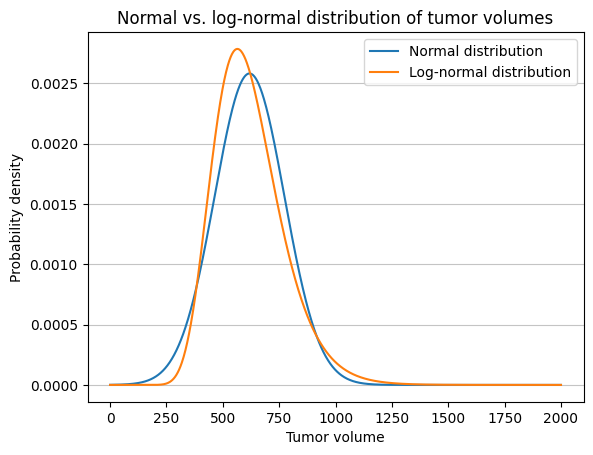

In [2]:
import matplotlib.pyplot as plt
from scipy.stats import norm, lognorm

# Initiating values for tumor_volume and residual_cv
tumor_volume = 600
residual_cv = 0.25

# Calculate parameters for the underlying normal distribution of the log-normal
mean_log = np.log(tumor_volume)
std_log = np.sqrt(np.log(residual_cv**2 + 1))

# Calculate the mean and SD of the equivalent normal distribution
mean_normal = np.exp(mean_log + std_log**2 / 2)
std_normal = np.sqrt((np.exp(std_log**2) - 1) *
                     np.exp(2*mean_log + std_log**2))
# When we use std = initial_tumor_volume * residual_cv, we're calculating the standard deviation
# directly from the initial tumor volume and the coefficient of variation. This is correct if
# residual_cv is the CV of the normal distribution. However, in the original simulation setup,
# residual_cv represents the coefficient of variation of the log-normal distribution,
# not the normal distribution.

# Create x values for plotting
x = np.linspace(0, 2000, 1000)

# Calculate PDF values for normal and log-normal distributions
normal_pdf = norm.pdf(x, loc=mean_normal, scale=std_normal)
lognormal_pdf = lognorm.pdf(x, s=std_log, scale=np.exp(mean_log))

# Plot the PDFs
plt.plot(x, normal_pdf, label='Normal distribution')
plt.plot(x, lognormal_pdf, label='Log-normal distribution')
plt.xlabel('Tumor volume')
# plt.xscale("log")
plt.ylabel('Probability density')
plt.title('Normal vs. log-normal distribution of tumor volumes')
plt.legend()
plt.grid(axis='y', alpha=0.75)

To demonstrate the statistical analysis techniques discussed in this chapter, we'll utilize a simulated dataset generated using the following parameters and assumptions:
- Experimental groups:
    - One control group (Vehicle).
    - Two single-agent therapy groups (Therapy_A, Therapy_B).
    - One combination therapy group (Therapy_Combo_AB).
- Sample size: each group starts with 15 animals (`n_animals = 15`).
- Study duration: the study lasts for 18 days (`duration = 18`).
- Initial tumor volume: all animals start with a tumor volume around 100 mm3 (`initial.tumor.volume = 100`).
- Measurement frequency: tumor volumes are measured every 3 days.
- Measurement error: the coefficient of variation (CV) for measurement error is 25% (`residual.cv = 0.25`).
- Tumor growth rates: average daily tumor growth rates (in %) are:
    - Vehicle: 5%
    - Therapy_A: 4.5%
    - Therapy_B: 3.5%
    - Therapy_Combo_AB: 1.3%
- Growth rate variability: the coefficient of variation for growth rates within each group is 10% (`growth.rate.cv = 0.1`).
- Maximum tumor volume: animals whose tumor volumes reach 2000 mm3 are removed from the study (`max.tumor.volume = 2000`).

In [3]:
# Set a seed for reproducibility
np.random.seed(444)

# Simulate the vehicle (control) group data
vehicle_group = simulate_exp_growth(
    group_name="control",
    duration=18,
    initial_tumor_volume=100,
    group_growth_rate_day_pct=5,
    growth_rate_cv=0.1,
    residual_cv=0.25,
    n_animals=15,
    max_tumor_volume=2000
)

# Simulate data for the single-agent therapy A group
therapy_a_group = simulate_exp_growth(
    group_name="therapy_a",
    duration=18,
    initial_tumor_volume=100,
    group_growth_rate_day_pct=4,
    growth_rate_cv=0.1,
    residual_cv=0.25,
    n_animals=15,
    max_tumor_volume=2000
)

# Simulate data for the single-agent therapy B group
therapy_b_group = simulate_exp_growth(
    group_name="therapy_b",
    duration=18,
    initial_tumor_volume=100,
    group_growth_rate_day_pct=3,
    growth_rate_cv=0.1,
    residual_cv=0.25,
    n_animals=15,
    max_tumor_volume=2000
)

# Simulate data for the combination therapy A+B group
therapy_ab_group = simulate_exp_growth(
    group_name="therapy_combo_ab",
    duration=18,
    initial_tumor_volume=100,
    group_growth_rate_day_pct=1.3,
    growth_rate_cv=0.1,
    residual_cv=0.25,
    n_animals=15,
    max_tumor_volume=2000
)

# Combine all group data into a single DataFrame
TGI_dataset = pd.concat(
    [
        vehicle_group,
        therapy_a_group,
        therapy_b_group,
        therapy_ab_group
    ],
    ignore_index=True
)

# Let's have a look at the dataset structure and values
print(TGI_dataset.head())

   day     animal    group          tv
0    0  control_1  control  103.815784
1    3  control_1  control  128.940403
2    6  control_1  control  176.041978
3    9  control_1  control  209.166393
4   12  control_1  control  442.556814


In [4]:
# For comparison with the R tutorial we can import the original TGI.dataset
TGI_dataset = pd.read_csv("TGI_dataset.csv")
TGI_dataset.columns = [col.lower() for col in TGI_dataset.columns]
for col in TGI_dataset.select_dtypes(include='object').columns:
    TGI_dataset[col] = TGI_dataset[col].astype(str).str.lower()
TGI_dataset.head(6)

,day,animal,group,tv
0,0,control_1,control,104.825993
1,3,control_1,control,125.137266
2,6,control_1,control,155.847247
3,9,control_1,control,238.687772
4,12,control_1,control,335.119128
5,15,control_1,control,729.343194


### Analyzing tumor growth dynamics

To gain deeper insights into the tumor growth patterns within each experimental group, we'll utilize a function to calculate summary statistics for tumor growth inhibition (TGI). This will allow us to compare the average tumor volumes across groups at different time points and assess the variability within each group.

In [5]:
def summary_stats_tgi(dataset: pd.DataFrame) -> pd.DataFrame:
    """Calculates geometric mean, standard error, and 95% confidence intervals 
        for tumor volumes per group per day.

    Args:
        dataset (pd.DataFrame): TGI dataset with columns 'day', 'group', and 'tv' (tumor volume).

    Returns:
        pd.DataFrame: Summary statistics with columns 'day', 'group', 'est' (geometric mean), 
        'se' (standard error), 'lb95_est' (lower 95% CI bound), and 'ub95_est' (upper 95% CI bound).
    """

    # Split the dataset by group and day
    grouped_data = dataset.groupby(['group', 'day'])

    # Apply the summary statistics calculation to each group
    summary_list = []
    for (group, day), group_df in grouped_data:
        # First, we take the natural logarithm of the tumor volumes
        # Drop missing values (NaN)
        log_tumor_volumes = np.log(group_df['tv'].dropna())

        # Analyze the log-transformed values using standard normal distribution techniques
        # To get back to the original scale (tumor volumes), we exponentiate the mean and confidence
        # interval limits. Since the exponential is the inverse of the logarithm, this back-transformation
        # gives us the geometric mean and the corresponding confidence interval on the original scale.
        geometric_mean = np.exp(np.mean(log_tumor_volumes))
        # In R, the default behavior of the var() function is to use a delta degrees of freedom (ddof) of 1.
        # This means it calculates the sample variance, which is considered an unbiased estimator of the
        # population variance. NumPy's np.var function, by default, uses ddof = 0 (population variance),
        # but not pandas's var.
        se = np.sqrt(log_tumor_volumes.var() / len(log_tumor_volumes))
        lb95 = geometric_mean * np.exp(norm.ppf(0.025) * se)
        ub95 = geometric_mean * np.exp(norm.ppf(0.975) * se)

        summary_list.append({
            "day": day,
            "group": group,
            "est": geometric_mean,
            "se": se,
            "lb95_est": lb95,
            "ub95_est": ub95
        })

    # Combine results into a DataFrame
    return pd.DataFrame(summary_list)

While we're simulating tumor volumes from a log-normal distribution, we actually use the normal distribution to calculate the mean and confidence intervals. The log-normal distribution is inherently defined as a distribution whose logarithm follows a normal distribution.  This means if a variable X is log-normally distributed, then $\log(X)$ follows a normal distribution.

When we want to calculate summary statistics like the mean and confidence interval for a log-normal distribution, it's often easier and more reliable to work with the logarithms of the data rather than the raw data itself. Indeed, the mean of the log-transformed data directly corresponds to the location parameter of the log-normal distribution. Also, the log-transformed data follows a normal distribution, which is symmetric. This symmetry makes it easier to calculate confidence intervals and apply standard statistical tests.

While it's theoretically possible to calculate summary statistics directly on the log-normal distribution, it's often more complex and prone to errors.  The log-normal distribution is skewed, so its arithmetic mean might not be a good representation of the central tendency. Additionally, calculating confidence intervals directly on the log-normal distribution can be computationally challenging.

In [6]:
TGI_stats = summary_stats_tgi(dataset=TGI_dataset)
print(TGI_stats)

    day             group          est        se     lb95_est     ub95_est
0     0           control   101.536731  0.034077    94.976633   108.549939
1     3           control   132.261775  0.061715   117.193124   149.267948
2     6           control   184.300154  0.064576   162.389861   209.166672
3     9           control   281.463182  0.102086   230.422992   343.809105
4    12           control   477.111360  0.125217   373.280079   609.824264
5    15           control  1169.973866  0.153067   866.732241  1579.309945
6    18           control  2750.176428  0.195191  1875.917983  4031.876902
7     0         therapy_a   103.594835  0.067338    90.786160   118.210638
8     3         therapy_a   105.617074  0.100664    86.705978   128.652794
9     6         therapy_a   136.011443  0.113316   108.923209   169.836279
10    9         therapy_a   195.629951  0.127840   152.271268   251.334860
11   12         therapy_a   312.601850  0.145064   235.240926   415.403554
12   15         therapy_a

Leveraging Pandas' `groupby` and `describe` functions, we can effortlessly generate a detailed statistical profile of the tumor volumes within each experimental group, including the number of animals remaining, at each time point.

In [7]:
TGI_dataset.groupby(['group', 'day']).describe()

tv                                                     \
                     count         mean          std         min          25%   
group            day                                                            
control          0    15.0   102.337373    12.879400   73.966753    98.079914   
                 3    15.0   135.822689    32.528511   83.542341   113.084926   
                 6    15.0   189.766983    47.882196  120.659156   159.487281   
                 9    15.0   301.584275   113.275488  120.438583   236.362885   
                 12   15.0   530.467881   247.383477  205.588181   333.563703   
                 15   15.0  1347.140701   670.145035  296.057302   870.395873   
                 18   15.0  3420.889383  2090.362199  463.809975  2017.002897   
therapy_a        0    15.0   106.963038    28.635230   58.913855    91.820106   
                 3    15.0   113.424589    45.696562   47.949666    84.560273   
                 6    15.0   147.484120    57.812170   45.955902   118.466128   
                 9    15.0   217.481620    99.489732   62.945368   155.360546   
                 12   15.0   356.223597   178.620840   84.066759   240.887216   
                 15   15.0   616.542902   287.643446  173.321385   412.393238   
                 18   15.0  1272.715957   616.831030  491.715154   830.020666   
therapy_b        0    15.0   101.622632    27.748183   68.683737    86.996987   
                 3    15.0   116.502890    45.676643   51.471512    77.642927   
                 6    15.0   159.943658    66.658128   71.677215   112.450580   
                 9    15.0   223.773995   105.409381   71.919811   148.479905   
                 12   15.0   320.154044   177.458595   85.357512   224.919608   
                 15   15.0   559.365932   385.954352  115.675295   370.667577   
                 18   15.0   847.034379   613.333316  183.144309   508.833347   
therapy_combo_ab 0    15.0    98.863617    21.913776   58.542840    80.452217   
                 3    15.0   102.033695    34.218192   56.524456    81.264018   
                 6    15.0   111.866578    58.485060   36.540022    75.760590   
                 9    15.0   130.357569    70.031341   37.381473    74.024599   
                 12   15.0   167.975680   109.856143   34.714108    84.479192   
                 15   15.0   213.252799   123.938002   40.303314   115.875287   
                 18   15.0   287.799543   203.230603   63.786859   150.290977   

                                                             
                              50%          75%          max  
group            day                                         
control          0     102.927819   108.765041   125.245267  
                 3     127.282145   159.104481   200.072588  
                 6     183.848327   218.303025   279.768096  
                 9     282.724282   359.417484   563.845041  
                 12    456.265546   707.509967   970.984050  
                 15   1286.366006  1795.646514  2831.206338  
                 18   3228.041028  4630.789148  8345.411255  
therapy_a        0      97.169935   113.085365   160.933938  
                 3      99.675973   131.490110   218.594997  
                 6     131.192080   187.781208   270.608753  
                 9     175.624492   272.227813   393.041179  
                 12    350.549399   423.646575   798.510798  
                 15    609.756321   768.338336  1300.752659  
                 18    939.946099  1727.996591  2449.440952  
therapy_b        0      94.462453   100.606739   173.368783  
                 3     111.360294   151.265746   190.062664  
                 6     152.966335   201.741230   285.400361  
                 9     211.324123   275.358286   430.777369  
                 12    283.700964   421.497751   704.788052  
                 15    443.944166   689.627500  1523.108747  
                 18    762.757727   939.605722  2468.363846  
therapy_combo_ab 0     1

The `pivot_table` function in Pandas is a powerful tool for generating custom summary tables, allowing us to easily compare geometric means of tumor volumes or other relevant metrics across different experimental conditions.

In [8]:
from scipy.stats import gmean

TGI_dataset.pivot_table(
    values='tv',
    index='day',
    columns='group',
    aggfunc=gmean
)

group,control,therapy_a,therapy_b,therapy_combo_ab
day,,,,
0,101.536731,103.594835,98.736314,96.364433
3,132.261775,105.617074,108.043137,97.289897
6,184.300154,136.011443,147.498501,99.155402
9,281.463182,195.629951,199.556878,111.844686
12,477.111360,312.601850,270.856421,136.879392
15,1169.973866,551.161945,443.544059,178.214612
18,2750.176428,1137.049884,677.167458,225.100813


### Visualizing tumor growth curves

#### Customized plotting function

To effectively visualize and compare the tumor growth patterns among the experimental groups, we'll create a plotting function that can display tumor growth curves with their associated confidence intervals. This will allow us to assess the impact of different therapies on tumor growth over time, both in the original scale and on the logarithmic scale.

In [9]:
def plot_tgi_stats(
    summ_stats: pd.DataFrame,
    ln_scale: bool = False,
    colormap: str = "viridis"
) -> None:
    """Plots tumor growth curves with 95% confidence intervals.

    Args:
        summ_stats (pd.DataFrame): Dataframe with summary statistics (output of `summary_stats_tgi`).
        ln_scale (bool, optional): If True, plot on natural log scale. Defaults to False.
        colormap (str, optional): Colormap to use for group colors. Defaults to "viridis".
    """

    # Map groups to colors and symbols
    groups = summ_stats["group"].unique()
    n_groups = len(groups)

    # Map groups to colors from the colormap, and markers
    colors = plt.get_cmap(colormap)(np.linspace(0.25, 1, n_groups))

    # Different markers for each group
    markers = ['o', 's', '^', 'D', '*', 'v', 'x', 'p']

    # Set up plot
    fig, ax = plt.subplots()

    # Plot each group
    for i, group in enumerate(groups):
        group_data = summ_stats[summ_stats["group"] == group]
        ax.errorbar(
            group_data["day"],
            group_data["est"],
            yerr=[
                group_data["est"] - group_data["lb95_est"],
                group_data["ub95_est"] - group_data["est"]
            ],
            fmt=markers[i],
            color=colors[i],
            label=group,
            capsize=5
        )
        ax.plot(group_data["day"], group_data["est"],
                color=colors[i], linewidth=2)

    # Formatting
    ax.set_xlabel("Days", fontsize=12)
    # Ensure x-axis ticks are integers
    ax.set_xticks(group_data['day'].unique())
    ax.set_xticklabels(group_data['day'].unique(), fontsize=10)
    if ln_scale:
        ax.set_yscale("log")
    ax.set_ylabel("Tumor volume (mm³)", fontsize=12)
    ax.set_title("Tumor growth curves", fontsize=14)
    ax.grid(which='major', axis='y', linestyle='--')
    ax.legend(loc='upper left', fontsize=10)

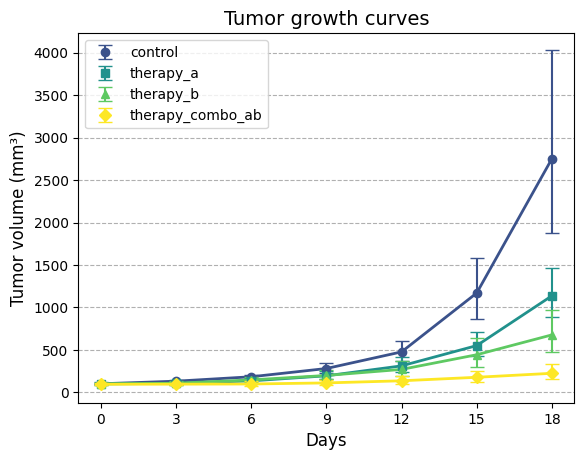

In [10]:
plot_tgi_stats(TGI_stats, ln_scale=False, colormap='viridis')

#### Versatile visualization with `seaborn`

[`Seaborn`](https://seaborn.pydata.org/index.html) is a powerful data visualization library built on top of Matplotlib. It offers a higher-level interface for creating informative and attractive **statistical graphics**, often with less code than Matplotlib. The code is much more concise and does not require a separate function to calculate summary statistics. It also handles the calculation of geometric means and [confidence intervals](https://sbwiecko.github.io/intuitive_biostatistics/12%20-%20Confidence%20Interval%20of%20a%20Mean.html) internally (using bootstrapping method). 

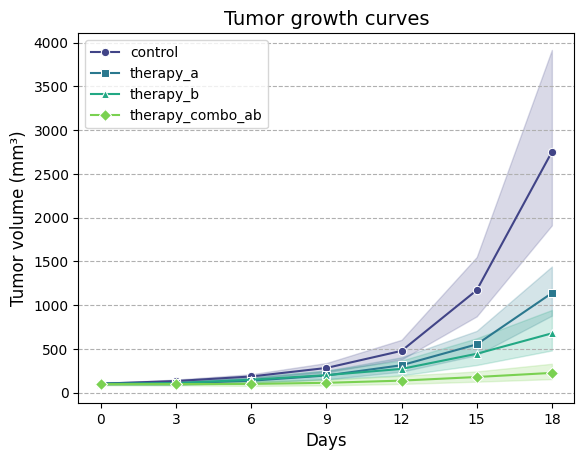

In [11]:
import seaborn as sns

# Create line plot of tumor volume over time for each group, using geometric mean
ax = sns.lineplot(
    # Input DataFrame containing tumor growth data, not the summary statistics
    data=TGI_dataset,
    x='day',                       # Column name for time points (x-axis)
    y='tv',                        # Column name for tumor volumes (y-axis)
    # Column name for grouping variable (different lines/colors for each group)
    hue='group',
    # Column name for assigning different line styles to groups (automatic)
    style='group',
    # Disable automatic dashes for different line styles (we'll use markers)
    dashes=False,
    markers=["o", "s", "^", "D"],  # Manually assign markers for each group
    estimator=gmean,               # Use geometric mean as the estimator for central tendency
    # Show 95% confidence intervals as error bars
    errorbar=('ci', 95),
    palette='viridis',             # Color palette to use for different groups
    # Show confidence intervals as filled bands around the lines
    err_style='band',
)

# Optionally plot on a logarithmic scale
# plt.yscale('log')
# Ensure x-axis ticks are integers
ax.set_xticks(TGI_dataset['day'].unique())
ax.set_xticklabels(TGI_dataset['day'].unique())
ax.set_xlabel("Days", fontsize=12)
ax.set_ylabel("Tumor volume (mm³)", fontsize=12)
ax.set_title("Tumor growth curves", fontsize=14)
ax.grid(which='major', axis='y', linestyle='--')
ax.legend(loc='upper left', fontsize=10)

#### Visualizing individual tumor growth trajectories

While summary statistics like the geometric mean and confidence intervals provide valuable insights into the average tumor growth trends, visualizing individual tumor growth curves offers a deeper understanding of the underlying variability and heterogeneity within each group. It allows us to identify outliers, observe patterns of response to treatment, and assess the overall distribution of tumor growth trajectories.

To facilitate this visualization, we'll create a function `plot_individual_curves` that automatically generates subplots, one for each group, displaying the individual growth curves of all animals within the group. This approach simplifies the plotting process, making it easier to explore the data and compare treatment effects across groups.

By examining these individual curves alongside the summary statistics, we can gain a more comprehensive picture of the tumor growth dynamics in our preclinical study. This holistic view can be crucial in interpreting the results, identifying potential issues with experimental design or data collection, and making informed decisions about the next steps in the drug development process.

In [12]:
def plot_individual_curves(
    dataset: pd.DataFrame,
    colormap: str = "viridis",
    max_cols: int = 2
) -> None:
    """Plots individual tumor growth curves for each animal, with one subplot per group.

    Args:
        dataset (pd.DataFrame): DataFrame with columns 'day', 'tv' (tumor volume), 'group', and 'animal'.
        colormap (str, optional): Colormap to use for group colors. Defaults to "viridis".
        max_cols (int, optional): Maximum number of columns in the plot grid. Defaults to 2.
    """

    groups = dataset["group"].unique()
    n_groups = len(groups)

    # Map groups to colors from the colormap
    colors = plt.get_cmap(colormap)(np.linspace(0.25, 1, n_groups))

    # Calculate number of rows and columns for subplots
    num_cols = min(n_groups, max_cols)
    num_rows = (n_groups + num_cols - 1) // num_cols

    # Find the maximum tumor volume across all groups
    max_tumor_volume = dataset['tv'].max()

    # Create the figure and axes
    fig, axes = plt.subplots(
        nrows=num_rows,
        ncols=num_cols,
        # Adjust figsize based on num_cols
        figsize=(3 * num_cols, 3 * num_rows),
        sharey=True,
    )

    # Flatten the axes array for easier iteration
    axes = axes.ravel()

    # Plot individual curves for each group
    for i, group in enumerate(groups):
        ax = axes[i]
        group_data = dataset[dataset["group"] == group]

        for animal in group_data["animal"].unique():
            animal_data = group_data[group_data["animal"] == animal]
            ax.plot(
                animal_data["day"],
                animal_data["tv"],
                color=colors[i],
                label=animal,
                lw=2)

        # Formatting
        ax.set_title(group)
        ax.set_xlabel("Days")
        ax.set_ylabel("Tumor volume (mm3)")
        ax.set_ylim(0, max_tumor_volume * 1.1)  # Set y-axis limits

    # Hide any unused subplots if the number of groups is not even
    for j in range(n_groups, num_cols * num_rows):
        axes[j].set_visible(False)

    # Add overall title and adjust layout
    plt.suptitle("Individual tumor growth curves")
    plt.tight_layout()
    plt.show()

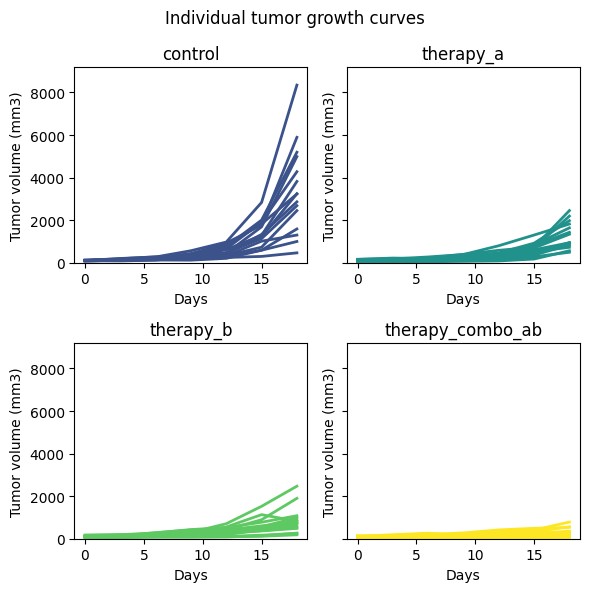

In [13]:
# Plot the current TGI_dataset
plot_individual_curves(TGI_dataset)

## Experimental design

### Overview of animal models in TGI studies

Preclinical TGI studies rely on various animal models, each with strengths and limitations that influence their suitability for different research questions. While no model perfectly replicates human tumors, careful model selection can improve research efficiency and reduce the risk of late-stage drug development failures.
1. Xenografts from human cancer cell lines:
    - Advantages: standardized, high-throughput screening, cost-effective.
    - Limitations: may not fully recapitulate the complexity of human tumors due to in vitro selection.
2. Patient-derived xenografts (PDX):
    - Advantages: can evaluate efficacy in heterogeneous populations, personalized medicine potential, biomarker hypothesis testing.
    - Limitations: costly, technically challenging, limited availability.
3. Subcutaneous vs. orthotopic xenografts:
    - Subcutaneous: easy to establish, monitor tumor growth with calipers.
    - Orthotopic: more accurately mimics tumor microenvironment, allows for studying invasion and metastasis.
    - Limitations (orthotopic): technically challenging, tumor measurement may require sacrifice or imaging.
4. Genetically engineered mouse models (GEMMs):
    - Advantages: recapitulate syngeneic tumor-host relationship, can study multiple endpoints (tumor growth, metastasis).
    - Limitations: asynchronous tumor development, long development time, difficult to measure deeply located tumors.
5. Organoid models:
    - Advantages: preserve tumor heterogeneity and microenvironment, standardized, controlled setting.
    - Limitations: still under development, utility in drug discovery needs further investigation.

The choice of animal model depends on the specific research question, budget, and available resources. While cell line xenografts offer high throughput and standardization, PDX models provide valuable insights into personalized treatment responses.  Orthotopic models offer a more realistic tumor microenvironment, while GEMMs allow for studying tumor-host interactions and multiple endpoints. Organoids hold promise for future research, but their applications are still being explored.

### Endpoints in preclinical TGI studies

Preclinical TGI studies assess how well a new therapy ($T$) inhibits tumor growth compared to a control group ($C$). Researchers have various options for choosing endpoints, which are the measures used to evaluate treatment effects.
1. **Tumor growth inhibition (TGI)**: this is a quantitative measure of how much a therapy reduces tumor size compared to the control. It's often expressed as a _percentage_ ($\text{TGI}\%$), where 0% indicates no inhibition and 100% indicates complete inhibition, or when the tumor completely stops growing or disappears.

    $$\text{TGI}_\text{T|C} = 1 - \frac{f(Y_T)}{f(Y_c)}$$

    where $f$ is a function whose output depends on $Y_T$ (treated group) and $Y_C$ (control group), based directly on tumor sizes or volumes, or derived from tumor volume measurements.
2. Derived endpoints from tumor volumes
    - Absolute tumor volume: the actual (average) size of the tumor _at a given time point_, i.e., $f(Y) = Y$.
    - **Change in tumor volume (∆TGI)**: the difference in tumor volume between the start and end of treatment, e.g., $f(Y) = Y_1 - Y_0$.
    - Area under the curve (AUC): the total area under the tumor growth curve over the study period.
    - Tumor growth rate: the rate at which the tumor grows over time.
3. Time-to-event (TTE) endpoints: these focus on the time it takes for a specific event to occur, such as tumor reaching a certain size, metastasis or animal death (although using death as an endpoint is discouraged for ethical reasons). TTE can be useful for seeing _long-term treatment impact_.
4. Categorical endpoints: This is a more qualitative way of looking at results. Instead of exact numbers, you put responses into **categories** like "complete response" (CR), "partial response" (PR), etc. This is similar to how results are often discussed in human cancer trials. The function $f$ in TTE can be conceptualized as comparing **relative risk** estimates between groups.

### Quantifying treatment effects

Having generated our simulated dataset and explored the individual tumor growth trajectories, we now need a way to quantify the effectiveness of the treatments in a standardized manner. For this purpose, we'll calculate two key metrics:
1. Tumor Growth Inhibition (TGI): this metric directly assesses the reduction in tumor size in the treated group compared to the control group at specific time points. A higher TGI indicates a more effective treatment.
2. TGI-Delta (∆TGI): this metric accounts for baseline tumor size differences between groups, providing a more nuanced view of treatment efficacy. It measures the change in tumor volume from a defined baseline time point, allowing for a comparison of growth changes rather than absolute sizes.

The following function, `calculate_tgi_from_data`, allows us to calculate either TGI or TGI-delta from our simulated dataset.

In [14]:
def calculate_tgi_from_data(
    dataset: pd.DataFrame,
    type: str = 'TGI',
    time_points: list = None,
    baseline: int = 0,
    treatment_name: str = None,
    control_name: str = "control"
) -> pd.DataFrame:
    """Calculates either TGI or TGI_delta from a tumor growth dataset.

    Args:
        dataset (pd.DataFrame): Dataframe with columns 'day', 'group', and 'tv' (Tumor Volume).
        type (str, optional): Types of TGI to calculate ('TGI' or 'TGI_delta'). Defaults to "TGI".
        time_points (list, optional): List of days at which to calculate TGI. If None, calculates for all days.
        baseline (int, optional): Baseline day for TGI_delta calculation. Required if 'TGI_delta' is in `type`.
        treatment_name (str, optional): Name of the treatment group. Defaults to None (calculates 
        for all groups vs. control).
        control_name (str, optional): Name of the vehicle (control) group. Defaults to "control".

    Returns:
        pd.DataFrame: DataFrame containing TGI or TGI_delta results.

    Raises:
        ValueError: If no treatment_name provided and no other group than control found in the dataset
    """

    # Ensure treatment_name is specified
    if not treatment_name:  # not None returns True
        non_control_groups = dataset[dataset['group']
                                     != control_name]['group'].unique()
        if len(non_control_groups) == 0:
            raise ValueError("No treatment groups found in the dataset.")
        # otherwise we take the first non-control group from the list as the treatment group
        treatment_name = non_control_groups[0]

    # Add baseline for calculating TGI_delta
    time_points = [baseline] + \
        time_points if type == "TGI_delta" else time_points

    # Filter control and treatment data
    control_data = dataset[(dataset["group"] == control_name) & (
        dataset["day"].isin(time_points))]
    treatment_data = dataset[(dataset["group"] == treatment_name) & (
        dataset["day"].isin(time_points))]

    # Calculate means
    control_means = control_data.groupby("day")["tv"].mean().reset_index()
    treatment_means = treatment_data.groupby("day")["tv"].mean().reset_index()

    # Calculate TGI or TGI_delta
    if type == "TGI":
        result_data = control_means.merge(
            treatment_means, on="day", suffixes=("_control", "_treatment"))
        result_data["tgi_pct"] = (
            1 - (result_data["tv_treatment"] / result_data["tv_control"])) * 100
        result_data["contrast"] = f"{treatment_name} vs. {control_name}"
        return result_data[["contrast", "day", "tgi_pct"]]

    elif type == "TGI_delta":
        control_baseline = control_data[control_data["day"] == baseline]
        treatment_baseline = treatment_data[treatment_data["day"] == baseline]

        # Calculate mean baseline tumor volumes for both groups
        control_baseline_mean = control_baseline["tv"].mean()
        treatment_baseline_mean = treatment_baseline["tv"].mean()

        # Adjust tumor volumes relative to their respective baseline means
        control_means["tv_control_adjusted"] = control_means["tv"] - \
            control_baseline_mean
        treatment_means["tv_treatment_adjusted"] = treatment_means["tv"] - \
            treatment_baseline_mean

        # Merge and calculate TGI_delta
        result_data = control_means.merge(treatment_means, on="day")
        result_data["tgi_delta_pct"] = (
            1 - (result_data["tv_treatment_adjusted"] / result_data["tv_control_adjusted"])) * 100
        result_data["contrast"] = f"{treatment_name} vs. {control_name}"

        # mask to exclude baseline from the report
        ix = result_data['day'] == baseline
        return result_data.loc[~ix, ["contrast", "day", "tgi_delta_pct"]]

    else:
        raise ValueError(
            "Invalid type. Please specify either 'TGI' or 'TGI_delta'.")

In [15]:
# Example 1 - Single time point TGI. Imagine we want to assess the efficacy of
# therapy_b compared to the control group at day 18 of the study.
calculate_tgi_from_data(
    dataset=TGI_dataset,
    type='TGI',
    time_points=[18, 21, 24, 27],  # it doesn't hurt if days don't exist
    treatment_name="therapy_b",
    control_name='control'
)

,contrast,day,tgi_pct
0,therapy_b vs. control,18,75.239352


In [16]:
# Example 2 - TGI-delta over multiple time points. If we're interested in
# how the effect of therapy_B changes over time, we can calculate TGI-delta
# at multiple time points relative to a baseline (e.g., day 0).
calculate_tgi_from_data(
    dataset=TGI_dataset,
    type='TGI_delta',
    time_points=[6, 12, 18],
    # baseline=0, # default
    treatment_name="therapy_b",
    # control_name='control'  # default name of the control group
)

,contrast,day,tgi_delta_pct
1,therapy_b vs. control,6,33.293736
2,therapy_b vs. control,12,48.956823
3,therapy_b vs. control,18,77.538042


Why Choose One Over the Other?
- TGI: use when the _baseline tumor volumes are relatively similar_ between the treated and control groups. This provides a straightforward measure of tumor reduction at specific time points.
- TGI-Delta: use when there are _notable differences in baseline tumor volumes_. TGI-delta accounts for this initial variation, focusing on the change in tumor growth relative to the starting point.

### Enhanced data analysis with Pandas

Pandas provides powerful tools for direct DataFrame manipulation, enabling efficient calculations like:
- Mean tumor volume: computing both arithmetic and geometric means for all treatment and control groups at each time point.
- TGI calculation (geometric mean): determining TGI for each treatment group at each time point, using the geometric means for a more accurate representation of the central tendency in log-normally distributed data.
- TGI-delta calculation (arithmetic mean): calculating ∆TGI for all treatment groups and time points, utilizing arithmetic means to account for differences in baseline tumor sizes, similarly to the function above.

By leveraging Pandas' capabilities, we can streamline these calculations and gain valuable insights into the effectiveness of different treatments on tumor growth, setting the stage for more in-depth statistical analysis.

In [17]:
# we apply arithmetic 'mean' and scipy gmean to tumor volumes
# grouped by treatment group and day
TGI_dataset.groupby(['group', 'day'])['tv'].agg(['mean', gmean])

mean        gmean
group            day                          
control          0     102.337373   101.536731
                 3     135.822689   132.261775
                 6     189.766983   184.300154
                 9     301.584275   281.463182
                 12    530.467881   477.111360
                 15   1347.140701  1169.973866
                 18   3420.889383  2750.176428
therapy_a        0     106.963038   103.594835
                 3     113.424589   105.617074
                 6     147.484120   136.011443
                 9     217.481620   195.629951
                 12    356.223597   312.601850
                 15    616.542902   551.161945
                 18   1272.715957  1137.049884
therapy_b        0     101.622632    98.736314
                 3     116.502890   108.043137
                 6     159.943658   147.498501
                 9     223.773995   199.556878
                 12    320.154044   270.856421
                 15    559.365932   443.544059
                 18    847.034379   677.167458
therapy_combo_ab 0      98.863617    96.364433
                 3     102.033695    97.289897
                 6     111.866578    99.155402
                 9     130.357569   111.844686
                 12    167.975680   136.879392
                 15    213.252799   178.214612
                 18    287.799543   225.100813

In [18]:
# TGI at multiple time-points
# use .xs to access values from each group in the hierarchical index
(
    TGI_dataset
    .groupby(['group', 'day'])
    .tv  # equivalent to ['tv']
    .mean()
    .transform(lambda x: 1 - x / x.xs('control', level=0))
    # pull out the outer-most index and push it up into columns
    .unstack(level=0)
)

group,control,therapy_a,therapy_b,therapy_combo_ab
day,,,,
0,0.0,-0.045200,0.006984,0.033944
3,0.0,0.164907,0.142243,0.248773
6,0.0,0.222815,0.157158,0.410506
9,0.0,0.278869,0.258005,0.567757
12,0.0,0.328473,0.396469,0.683344
15,0.0,0.542332,0.584775,0.841700
18,0.0,0.627958,0.752394,0.915870


In [19]:
# Adjusted geometric means of the tumor volume
(
    TGI_dataset
    .groupby(['group', 'day'])
    .agg(adjusted_geometric_mean=('tv', gmean))  # named aggregation
    .transform(lambda x: x - x.xs(0, level=1))
    .unstack(level='group')
)

adjusted_geometric_mean                                          
group                 control    therapy_a   therapy_b therapy_combo_ab
day                                                                    
0                    0.000000     0.000000    0.000000         0.000000
3                   30.725044     2.022239    9.306823         0.925464
6                   82.763423    32.416607   48.762187         2.790968
9                  179.926451    92.035116  100.820564        15.480252
12                 375.574628   209.007015  172.120106        40.514959
15                1068.437135   447.567110  344.807745        81.850178
18                2648.639697  1033.455049  578.431143       128.736380

In [20]:
# TGI-delta (arithmetic mean) over all groups and time points
(
    TGI_dataset
    .groupby(['group', 'day'])
    ['tv']
    .agg(TGI_delta_arithmetic_mean='mean')
    .transform(lambda x: x - x.xs(0, level=1))
    .transform(lambda x: 1 - x/x.xs('control', level=0))
    .unstack(level='group')
)

TGI_delta_arithmetic_mean                                     
group                   control therapy_a therapy_b therapy_combo_ab
day                                                                 
0                           NaN       NaN       NaN              NaN
3                           0.0  0.807033  0.555618         0.905329
6                           0.0  0.536529  0.332937         0.851275
9                           0.0  0.445318  0.386935         0.841935
12                          0.0  0.417793  0.489568         0.838572
15                          0.0  0.590634  0.632277         0.908107
18                          0.0  0.648716  0.775380         0.943067

Statistics play a crucial role in analyzing the data collected using these endpoints. Since we often assume tumor growth data follows a log-normal distribution, we might use **geometric means** (instead of arithmetic means) to better represent the central tendency of the data. This is especially important for studies with multiple time points where we need to summarize complex growth patterns.

### Measuring tumor volume in preclinical studies

Accurately measuring tumor volume in animal studies is essential for evaluating how well a treatment works, as tumor size is linked to the number of active cancer cells. Different methods exist, each with its own advantages and drawbacks:
1. Ex vivo weighing: this involves surgically removing the tumor and weighing it, offering precise volume measurements. However, it's limited to a single time point at the end of the study.
2. In vivo caliper measurements: this non-invasive method is quick and suitable for easily accessible tumors (e.g., those implanted under the skin). It involves measuring tumor dimensions (length, width, and height) and calculating volume using geometric formulas. Tumor volume is often calculated assuming an ellipsoid shape ($Y = 1/6 \pi \times L \times W \times H$), where $L$ is the length, $W$ the width and $H$ the height, or a simplified approximation for equal height and width ($Y = 1/2 \times L \times W^2$).
3. Imaging techniques (MRI, CT, Ultrasound): for deeply located tumors, imaging methods provide detailed internal views and precise measurements, even for complex shapes. However, these techniques can be costly and raise ethical concerns due to the need for anesthesia and potential stress on animals.

Choosing the right measurement method depends on factors like tumor type, location, desired accuracy, study duration, and ethical considerations.

### Understanding and mitigating measurement errors in TGI studies

Measurement errors, both systematic (bias) and random, are inherent to any technique used to measure tumor size in animal studies. These errors can significantly affect the accuracy, precision, and validity of preclinical research findings.

Types of measurement errors:
- Bias (systematic errors): these are consistent deviations from the true tumor size, often caused by factors such as instrument limitations, observer variability, or assumptions about tumor shape. Caliper-based measurements, while convenient and cost-effective, are particularly prone to bias due to factors like tissue interference and subjective interpretation.
- Random errors: these are unpredictable fluctuations in measurements that affect the precision of the results. While _unavoidable_, their magnitude can be _reduced_ through experience, training, and standardized procedures.

Impact of measurement errors:
- Bias: if not addressed, bias can lead to **inaccurate** conclusions about the effectiveness of a treatment. For example, a biased measurement tool might consistently overestimate tumor size in one group, leading to an incorrect conclusion about treatment efficacy.
- Precision: random errors reduce the **precision** of measurements, making it harder to detect statistically significant differences between treatment groups. This can result in inconclusive results or underpowered studies.

Strategies for mitigating measurement errors:
- Study design: **randomization, blinding, and stratification** can help minimize bias and ensure **balanced** groups.
- Measurement techniques: choose the most appropriate technique based on the tumor type, location, and desired accuracy. Imaging techniques (MRI, CT, ultrasound) are generally more precise but can be costly and raise animal welfare concerns.
- Standardization and training: consistent use of instruments, standardized protocols, proper quality control, and extensive training can reduce both bias and random error.

Additional considerations:
- Small tumor volumes: measurement _accuracy tends to decrease for small tumors_ due to equipment limitations and the challenges of measuring irregular or inflamed tissues.
- Noise in data: even with careful design, TGI studies can produce _noisy data_. Sample size calculations are crucial to ensure sufficient statistical power to detect treatment effects despite this noise.

By understanding and addressing measurement errors, researchers can improve the reliability and validity of their preclinical studies, leading to more informed decisions about promising cancer therapies.

### Handling discrepant measurements and missing data in TGI studies

In preclinical TGI studies, unexpected or missing data points can occur. It's essential to have a clear plan for dealing with these issues to maintain the validity and integrity of the study's conclusions.

Discrepant measurements (**outliers**):
- When to exclude: remove outliers only if there's a clear understanding of a specific error during the study (e.g., incorrect dosage, tumor cell engraftment issue). These **exclusion criteria** should be defined in advance.
- When to include: if there's no obvious error, it's best to include all animals to avoid introducing bias. **Non-parametric** tests can be helpful as they're less sensitive to outliers.

Missing Data:
- Random missingness:
  - MCAR (missing completely at random): no systematic difference between animals with missing and complete data.
  - MAR (missing at random): missingness is explainable by a known factor unrelated to treatment or response (e.g., cage-specific illness).
- Informative censoring: missingness is more likely in certain groups. Two common scenarios:
  - Large tumors: animals are sacrificed due to welfare concerns (usually >2000 mm³). This can lead to underestimation of tumor volume in untreated groups.
  - Small tumors: highly effective treatments shrink tumors below the detection limit (<50 mm³). This can lead to bias and imprecision in estimates.

Handling informative censoring:
- Limited analysis: one option is to analyze TGI only up to the time point when the first animal was removed due to tumor size.
- Time-to-event analysis: another approach is to use time-to-event analysis, where the "event" is the tumor reaching a large size. This eliminates the issue of informative censoring related to large tumor sizes.

Key points:
- Handling missing data and outliers requires careful consideration to avoid introducing bias.
- Pre-specifying criteria for data exclusion is crucial for maintaining objectivity.
- Different approaches are suitable depending on the type of missingness or outlier.
- Time-to-event analysis can be a valuable tool when dealing with informative censoring due to large tumor volumes.

## Statistical analysis in preclinical cancer studies

After measuring tumor volumes in animal studies, the standard method to assess the impact of anticancer treatments is to determine whether there are **statistically significant** differences between treatment and control groups. The choice of statistical test depends on several factors:
- Study endpoint: whether the endpoint is continuous (tumor volume, growth rate), time-to-event (tumor progression, death), or categorical (tumor response categories).
- Number of time points: whether the study involves a single time point assessment or multiple measurements over time.
- Parametric vs. non-parametric: whether the data meet the assumptions of parametric tests (e.g., normality) or require non-parametric methods.

The appropriate statistical test will vary based on these factors. For example, t-tests or ANOVA might be used for continuous endpoints at a single time point, while repeated measures ANOVA or mixed models might be used for longitudinal data:

```text
Data
|
|-- Categorical (compare frequencies)
|   |-- Chi-squared tests (trend is not important)
|   `-- Cochran-Armitage (trend is mportant)
|
|-- Continuous (typical TGI)
|   |
|   |-- Single time-point (usually last day of study)
|   |   |-- T-tests or ANOVAs (with/without adjustment for covariates)
|   |   `-- Bliss or HSA (analysis of synergy)
|   |
|   `-- Multiple time-points (several assessments throughout study)
|       |-- Growth rates or AUCs (summarizes into a few parameters)
|       |-- T-tests, ANOVAs, or ANCOVAs (with/without covariates, assessment at each time point)
|   |   `-- Bliss or HSA (analysis of synergy)
|
`-- Time-to-event (modeling events)
    |-- Log-rank tests (non-parametric)
    `-- Cox Proportional Hazards models (semi-parametric with/without adjustment for covariates)
```

### Analyzing continuous tumor volume data at a single time point

In TGI studies where tumor volume is measured only once (usually at the end of the study), the data can be analyzed as follows:
- Data structure: the tumor volume data ($Y$) is represented as $y_{ij}$, where:
  - $i$ is the index for each individual animal ($i = 1, \dots, N$) where $N$ is the total number of animals.
  - $j$ is the index for the treatment group ($j = 1, \dots, J$) where $J$ is the number of groups.
- Log transformation: tumor volumes are often log-transformed due to their right-skewed distribution.
  $$\stackrel{*}{y_{ij}} = \ln(y)$$
  Log-transforming tumor volumes in TGI studies offers several advantages:
    - Normality: log-transformation helps normalize the data, making it suitable for parametric statistical tests that assume a normal distribution.
    - Equal variances: it can also help **stabilize the variance** across different groups, making them more comparable.
    - Reduced degrees of freedom: avoids using up degrees of freedom for testing normality and equal variances after transformations.
    - Interpretable differences: transforms differences between groups into fractions, eliminating counter-intuitive negative growth rates.
    - Enables parametric methods: allows for using standard parametric tests like t-tests (for two groups, $J = 2$) or ANOVA (for multiple groups, $J \ge 2$) or linear regression models, which are often more powerful than their non-parametric counterparts.
- Handling zeros: if some tumor volumes are zero, they can be replaced with the smallest measurable tumor volume to avoid issues with log transformation, especially when there are only a few zero measurements.

This approach allows researchers to apply standard statistical tests (e.g., t-tests, ANOVA) to compare the average log-transformed tumor volumes between treatment groups, and then back-transform the results to the original volume scale.

#### How it works

In TGI studies with a single time point and continuous tumor volume data, a simple linear regression model or ANOVA can be used for statistical analysis.

1. Log transformation: tumor volumes $Y$ are log-transformed $\ln(Y)$ to meet the normality assumption of the model.
2. Model setup: the core idea behind this model is that the log-transformed tumor volume of each animal ($i$) is influenced by the treatment group ($j$) the animal belongs to.

    The model assumes that each treatment group has a potentially different average effect on the tumor volume, and this effect is captured by the parameters $\alpha_j$. The mathematical equation that describes the model is $\stackrel{*}{y_{i}} = \sum_{j=1}^J{\alpha_j I_{ij} + \epsilon_i}$, where $I_{ij} = 1$ indicates the treatment $j$ to which each animal $i$ was assigned to, otherwise $I_{ij} = 0$, i.e., the animal $i$ is not in group $j$ if $I_{ij} = 0$, and $\epsilon_i$ is the residual error term for animal $i$, representing the variation in tumor volume that is not explained by the treatment group. The model assumes these errors are normally distributed with mean 0 and variance $\sigma^2$, i.e., $\epsilon_i \sim N(0, \sigma^2)$.

    For example, let's consider two groups, control ($j = 1$), and treatment A ($j = 2$). For an animal in the control group, $I_{i1} = 1, I_{i2} = 0$, the equation becomes $\stackrel{*}{y_i} = \alpha_1 + \epsilon_i$. For an animal in treatment A, the equation becomes $\stackrel{*}{y_i} = \alpha_2 + \epsilon_i$.
  
    The model parameters represent:
    - $\alpha_1$: the mean log tumor volume in the control group (intercept). It's the value we would expect if the animal received no treatment.
     - $\alpha_2, \alpha_3, \dots, \alpha_J$: the mean differences in log tumor volume between each treatment group and the control group (treatment effects).

3. Parameter estimation: ordinary least squares (OLS) is used to estimate the model parameters.
4. Hypothesis testing: statistical tests like score tests or Wald tests can be used to assess the significance of the treatment effects.
  - One-sided tests: used to test if a treatment reduces tumor volume compared to the control (H1: $\alpha_j \lt 0$).
  - Two-sided tests: used to compare the tumor reduction efficacy between different treatments (H1: $\alpha_2 \ne \alpha_3$).

Essentially, the model allows us to estimate the average effect of each treatment on the log tumor volume, taking into account the natural variability between animals. By fitting this model to the data, we can then perform statistical tests to see if the treatment effects are significantly different from zero (i.e., if the treatments are actually working).

#### Model-based estimation of the TGI

Let's now incorporate the predicted/estimated average tumor volume in the treatment group ($j = T$) and in the control group ($j = 1$) based on the linear model, with $\widehat{Y_T} = e^{\widehat{\alpha_1} + \widehat{\alpha_T}}$ and $\widehat{Y_1} = e^{\widehat{\alpha_1}}$, where $\widehat{\alpha_1}$ is the estimated mean of the log-transformed tumor volumes in the control group (intercept of the linear model), and $\widehat{\alpha_T}$  is the estimated difference in mean log tumor volume between the treatment group (T) and the control group, i.e., it quantifies the treatment effect on the log scale.

The model works with log-transformed tumor volumes. However, to calculate TGI, we need to go back to the original scale (the actual tumor volumes). To do this, we exponentiate the log-transformed values.

As discussed earlier, the TGI is defined as the percentage reduction in tumor volume in the treatment group compared to the control group. Mathematically, this is $\text{TGI}_\text{T|1} = 1 - \frac{f(Y_T)}{f(Y_1)}$. In the model, we estimate the parameters $\alpha_T$ and $\alpha_1$ using ordinary least squares (OLS). We denote these estimates as $\widehat{\alpha_T}$ and $\widehat{\alpha_1}$. Substituting these estimates into the TGI formula, we get $\widehat{\text{TGI}_\text{T|1}} = 1 - \frac{e^{\widehat{\alpha_1} + \widehat{\alpha_T}}}{e^{\widehat{\alpha_1}}}$. Using the property that $e^{a+b} = e^a \times e^b$, we can simplify:

$$\widehat{\text{TGI}_\text{T|1}} = 1 - e^{\widehat{\alpha_T}}$$

By using the model-based estimates ($\widehat{\alpha_1}$ and $\widehat{\alpha_T}$), you're taking into account all the data points from both groups and adjusting for other factors that might influence tumor growth (e.g., baseline differences between animals). This approach can provide more accurate and reliable TGI estimates than simply comparing the raw average tumor volumes.

_Note that this method assumes that the linear model is a good fit for the log-transformed tumor volume data._

#### Practical example

Suppose our linear model estimates are $\widehat{\alpha_1} = 4.6$, i.e., the mean log tumor volume in the control group, and $\widehat{\alpha_T} = -0.5$, i.e., the treatment effect for group T indicating a reduction in tumor volume compared to control. Then the estimated TGI would be $\widehat{\text{TGI}_{T|1}} = 1 - \exp(-0.5) \approx 0.393$. This means that the treatment is estimated to reduce the average tumor volume by approximately 39.3% compared to the control group at the end of the study.

#### TGI analysis for single time-point data in Python

In scenarios where tumor volume measurements are taken at a single time point (typically at the end of the study), we can employ a linear model to compare the treatment group(s) to the control group. This analysis allows us to determine if there are statistically significant differences in tumor growth inhibition (TGI) between the groups.

The following function, tgi_single_time, implements this analysis. It offers flexibility to either adjust for baseline tumor volumes or analyze the raw tumor volumes directly. Additionally, it allows for both one-sided (testing for tumor reduction) and two-sided (testing for differences in efficacy) hypothesis tests.

In [21]:
from typing import List
import statsmodels.formula.api as smf


def tgi_single_time(
    dataset: pd.DataFrame,
    time_point: int,
    treatments_numerator: List[str],
    treatment_denominator: str = 'control',
    baseline_adjusted: bool = False,
    baseline: int = 0,
    p_tails: int = 1,
    correction_method: str = 'none',
) -> pd.DataFrame:
    """Estimates Tumor Growth Inhibition (TGI) at a single time point using a linear model.

    Args:
        dataset (pd.DataFrame): DataFrame with columns 'day', 'group', and 'tv' (tumor volume).
        time_point (int): Day at which to calculate TGI.
        treatments_numerator (List[str]): List of treatment group names (numerators in TGI calculation).
        treatment_denominator (str): Name of the comparison group (denominator in TGI calculation).
        Defaults to 'control'.
        baseline_adjusted (bool, optional): If True, adjust for baseline tumor volume. Defaults to False.
        baseline (int, optional): Baseline day for adjustment. Defaults to 0.
        p_tails (int, optional): Number of tails for the hypothesis test (1 for one-sided, 2 for two-sided).
        Defaults to 1.
        correction_method (str, optional): Method for multiple comparisons correction ('none', 'bonferroni', 
        'sidak'). Defaults to 'none'.

    Returns:
        pd.DataFrame: DataFrame containing TGI estimate, confidence intervals, and P-value.
    """

    # Filter data for the relevant time points and groups
    tv_data = dataset[
        (dataset['day'].isin([baseline, time_point]))
        &
        (dataset['group'].isin(treatments_numerator + [treatment_denominator]))
    ].copy()

    # Log-transform tumor volume (TV) and add lnTV column
    tv_data['log_tv'] = np.log(tv_data['tv'])

    # Baseline adjustment (if applicable)
    if baseline_adjusted:
        tv_data['log_tv_baseline'] = (
            tv_data
            .groupby('animal')  # we pick for each animal
            .log_tv             # the log_tv value
            .transform('first')  # of the first day, i.e., day 0
        )

    # We filter the time point we want to analyze
    tv_data = tv_data[tv_data['day'] == time_point]

    # Build and fit the linear model
    if baseline_adjusted:
        model = smf.ols(
            formula=f"log_tv ~ log_tv_baseline + C(group, Treatment(reference='{
                treatment_denominator}'))",
            data=tv_data)
    else:
        model = smf.ols(
            formula=f"log_tv ~ C(group, Treatment(reference='{
                treatment_denominator}'))",
            data=tv_data)
    est = model.fit()

    degrees_of_freedom = est.df_resid

    # Extract model estimates and calculate TGI
    # print(est.summary2())
    results = est.summary2().tables[1]  # returns a true DataFrame

    # Create a list to store the final results for all treatments
    model_estimates_list = []
    for treatment in treatments_numerator:
        # Extract TGI, CI, and P-value for the current treatment
        ix = f"C(group, Treatment(reference='{
            treatment_denominator}'))[T.{treatment}]"
        tgi = (1 - np.exp(results.loc[ix, "Coef."]))

        # Calculate confidence intervals and p-value
        std_err = results.loc[ix, "Std.Err."]

        if p_tails == 1:
            lb95_tgi = np.nan
            ub95_tgi = (
                1 - np.exp(results.loc[ix, "Coef."] + t_dist.ppf(0.95, degrees_of_freedom) * std_err))
            pvalue = t_dist.cdf(results.loc[ix, "t"], degrees_of_freedom)
        else:
            lb95_tgi = (
                1 - np.exp(results.loc[ix, "Coef."] + t_dist.ppf(0.025, degrees_of_freedom) * std_err))
            ub95_tgi = (
                1 - np.exp(results.loc[ix, "Coef."] + t_dist.ppf(0.975, degrees_of_freedom) * std_err))
            pvalue = 2 * \
                (1 - t_dist.cdf(abs(results.loc[ix, "t"]), degrees_of_freedom))

        # Adjust p-values if multiple comparison correction is specified
        if correction_method == 'bonferroni':
            pvalue *= len(treatments_numerator)
        elif correction_method == 'sidak':
            pvalue = 1 - (1 - pvalue) ** len(treatments_numerator)

        # Create a dataframe of the results for the current treatment
        model_estimates = pd.DataFrame({
            "contrast": [f"{treatment} vs. {treatment_denominator}"],
            "day": [time_point],
            "tgi": [tgi],
            "lb95_tgi": [lb95_tgi],
            "ub95_tgi": [ub95_tgi],
            "pvalue": [pvalue],
            "df": [degrees_of_freedom],
            "baseline_adj": [baseline_adjusted],
            "correction": [correction_method],
        })

        # Append results for this treatment to the list
        model_estimates_list.append(model_estimates)

    # Combine results into a single DataFrame
    return pd.concat(model_estimates_list, ignore_index=True)

Now that we have our `tgi_single_time` function defined, let's explore how it can be used to answer different questions about the efficacy of our simulated cancer therapies.

- Example 1: baseline-adjusted TGI of 'therapy_a' and 'therapy_b' at day 18

Tumors often vary in size at the start of a study due to biological or experimental factors. Adjusting for baseline tumor volume helps control for this initial variability, making the comparison between treatment and control groups fairer and more focused on the treatment effect itself.

In [22]:
tgi_single_time(
    TGI_dataset,
    time_point=18,
    treatments_numerator=['therapy_a', 'therapy_b'],
    treatment_denominator='control',  # default
    baseline_adjusted=True,
    baseline=0,  # default
    p_tails=1,  # default
)

,contrast,day,tgi,lb95_tgi,ub95_tgi,pvalue,df,baseline_adj,correction
0,therapy_a vs. control,18,0.594287,NaN,0.399294,1.922899e-04,41.0,True,none
1,therapy_b vs. control,18,0.747207,NaN,0.625606,3.074967e-07,41.0,True,none


This call assesses the tumor growth inhibition of 'therapy_a' and 'therapy_b' compared to the 'control' group at day 18, taking into account the baseline tumor volumes (day 0). We use `baseline_adjusted=True` because we want to control for any potential differences in initial tumor sizes between the two groups. This focuses the analysis on the effect of the treatment itself, not just the final tumor size. We specify `baseline=0` to indicate that the baseline measurements were taken on day 0 of the study, though this is the default function parameter. Similarly, we specify the treatment denominator group `treatment_denominator='control'` although this is the default control group name.

- Example 2: unadjusted TGI of 'therapy_a' and 'therapy_b' at day 18

When there are substantial differences in baseline tumor sizes, not adjusting for them can lead to biased estimates of the treatment effect. By including baseline as a covariate, we can obtain more accurate estimates of how much the treatment actually influences tumor growth. If we're unsure whether to adjust for baseline, we can perform a sensitivity analysis by fitting the model both with and without the baseline adjustment and compare the results. If the results are similar, then adjusting might not be necessary.

In [23]:
tgi_single_time(TGI_dataset, time_point=18,
                treatments_numerator=['therapy_a', 'therapy_b'])

,contrast,day,tgi,lb95_tgi,ub95_tgi,pvalue,df,baseline_adj,correction
0,therapy_a vs. control,18,0.586554,NaN,0.378781,3.613441e-04,42.0,False,none
1,therapy_b vs. control,18,0.753773,NaN,0.630035,3.985567e-07,42.0,False,none


Similar to example 1, this call calculates the TGI of 'therapy_a' and 'therapy_b' at day 18. However, it doesn't adjust for the baseline tumor volumes. We might choose not to adjust for the baseline if we are confident that the initial tumor sizes were very similar between the groups or if we want to see the raw effect of the treatment without considering baseline differences. Here we can see that the TGI values are comparable in both cases, and that the P values don't change the conclusion, sugesting that baseline adjustment may not be necessary.

Note that the difference in degrees of freedom between baseline-adjusted and unadjusted models is expected and statistically valid. It reflects the fact that we're estimating an additional parameter when adjusting for baseline, which consumes one degree of freedom from the data. Generally, a lower 'df_residual' leads to slightly wider confidence intervals and potentially less significant P-values, as the model has less flexibility to fit the data. While adjusting for a significant covariate can increase power, adjusting for a non-significant covariate can actually decrease power. This is because we're using up a degree of freedom without gaining much explanatory power in return.

Ideally, the decision of whether to adjust for baseline should be made before the study begins and documented in the study protocol. This helps avoid bias and ensures the analysis plan is consistent with the study design.

- Example 3: two-sided unadjusted TGI comparison of 'therapy_combo_ab' vs. 'therapy_b' at day 12

In [24]:
tgi_single_time(TGI_dataset, time_point=12, treatments_numerator=[
                'therapy_combo_ab'], treatment_denominator='therapy_b', p_tails=2)

,contrast,day,tgi,lb95_tgi,ub95_tgi,pvalue,df,baseline_adj,correction
0,therapy_combo_ab vs. therapy_b,12,0.494642,0.691727,0.171558,0.008549,28.0,False,none


This call compares the efficacy of the combination therapy (therapy_combo_ab) to therapy_b at day 12. We use `p_tails=2` for a two-sided hypothesis test because we're interested in whether the combination therapy is either better or worse than therapy_b, not just whether it's better. We explicitly set `treatment_denominator='therapy_B'` to indicate that we're comparing the combination therapy to therapy_b, not the control group. In this example, we don't adjust for baseline since we're directly comparing two treatment groups, not a treatment to the control. We're assuming that any baseline differences would affect both groups similarly.

#### The problem with multiple pairwise t-tests (j > 2)

Imagine you have three treatment groups (A, B, and C) and want to compare them all. If you perform multiple pairwise t-tests (A vs. B, A vs. C, B vs. C), [you encounter several issues](https://sbwiecko.github.io/intuitive_biostatistics/15%20-%20P%20Values%20and%20Statistical%20Significance.html#the-challenge-of-multiple-comparisons):
1. Inflated type I error rate: each individual t-test has a chance of making a type I error (false positive), typically set at 5%. When you conduct multiple tests, the overall probability of making at least one false positive increases substantially. This means you're more likely to conclude that a treatment difference exists when it actually doesn't.
2. Inefficient variance estimation: each t-test only uses the data from the two groups being compared to estimate the variance. This ignores the information from the other groups, potentially leading to less accurate and less stable variance estimates.

A simple linear model (or ANOVA in this case) with pairwise contrasts addresses these problems:
1. Controls for type I error: by performing a single overall test (e.g., F-test in ANOVA), you control the family-wise error rate, which is the probability of making at least one type I error across all comparisons. This ensures a more stringent threshold for declaring statistical significance.
2. [Pooled variance](https://sbwiecko.github.io/intuitive_biostatistics/20%20-%20Statistical%20Power%20and%20Sample%20Size.html#the-effect-size) estimation: the linear model estimates the variance $\sigma^2$ by pooling information from all the groups. This leads to a more reliable and efficient estimate, especially when sample sizes are small.
3. Pairwise comparisons with adjustment: after the overall test indicates a significant difference, you can perform pairwise comparisons using contrasts. These contrasts can be adjusted for multiple comparisons (e.g., using Tukey's HSD), further controlling the type I error rate.

Let's illustrate how to use the Bonferroni adjustment for multiple comparisons implement in the `tgi_single_time` function. This adjustment will ensure that we control the family-wise error rate when comparing multiple treatment groups to the control.

In [25]:
tgi_single_time(
    TGI_dataset,
    time_point=12,
    treatments_numerator=['therapy_a', 'therapy_b', 'therapy_combo_ab'],
    correction_method='bonferroni')

,contrast,day,tgi,lb95_tgi,ub95_tgi,pvalue,df,baseline_adj,correction
0,therapy_a vs. control,12,0.344803,NaN,0.056728,8.602930e-02,56.0,False,bonferroni
1,therapy_b vs. control,12,0.432299,NaN,0.182694,1.792068e-02,56.0,False,bonferroni
2,therapy_combo_ab vs. control,12,0.713108,NaN,0.586968,6.225085e-07,56.0,False,bonferroni


In [26]:
tgi_single_time(
    TGI_dataset,
    time_point=12,
    treatments_numerator=['therapy_a', 'therapy_b', 'therapy_combo_ab'],
    correction_method=None)

,contrast,day,tgi,lb95_tgi,ub95_tgi,pvalue,df,baseline_adj,correction
0,therapy_a vs. control,12,0.344803,NaN,0.056728,2.867643e-02,56.0,False,None
1,therapy_b vs. control,12,0.432299,NaN,0.182694,5.973560e-03,56.0,False,None
2,therapy_combo_ab vs. control,12,0.713108,NaN,0.586968,2.075028e-07,56.0,False,None


#### Note on the regression model formula

In a typical linear regression model (with an intercept), the **intercept** represents the average predicted value of the outcome variable when all predictor variables are zero. It serves as a baseline reference point. For example, in the model `log_tv ~ group`, the intercept represents the average log tumor volume for the reference group (typically the control group). The coefficients for each treatment group then indicate how much their average log tumor volume _differs_ from the control group's average.

When you add `- 1` to the formula `log_tv ~ group - 1`, we're explicitly telling the model not to include an intercept term. This has two key effects:
1. Change in interpretation: the coefficients now represent the _absolute_ average log tumor volumes for each group, not the differences from a reference group. There's no longer a baseline value that the treatment effects are compared to.
2. Change in calculation: the model no longer tries to find a single intercept that best fits all groups. Instead, it estimates separate intercepts for each group, essentially allowing each group's average log tumor volume to vary independently.

Imagine we have two groups with the following log tumor volumes:
- Control: [4.5, 4.6, 4.7]
- Treatment: [4.2, 4.3, 4.4]

The intercept $\alpha$ (which is different from the $\alpha_1, \alpha_2, \dots, \alpha_J$ coefficients defining the TGI model) might be estimated as 4.6 (the average of the control group), and the coefficient for the treatment group $\beta$ would be -0.3 (the average difference from the control group), using a model with intercept. With a model without intercept, the coefficients would be estimated directly as the mean of each group, i.e., 4.6 for the control group, and 4.3 for the treatment group.

If there's a strong theoretical reason to believe that the outcome variable should be zero when all predictors are zero, we might want to force a zero intercept.

In [27]:
# Example dataset for this demonstration
tv_data = TGI_dataset[
    (TGI_dataset['group'].isin(['therapy_b', 'control']))
].copy()

# Log transformation
tv_data['log_tv'] = np.log(tv_data['tv'])

# Putting the baseline tumor volume in column
tv_data['log_tv_baseline'] = (
    tv_data
    .groupby('animal')  # we pick for each animal
    .log_tv             # the log_tv value
    .transform('first')  # of the first day, i.e., day 0
)

# Keeping only the data point we want to analyze
tv_data = tv_data[tv_data['day'] == 18]

tv_data.head()

,day,animal,group,tv,log_tv,log_tv_baseline
6,18,control_1,control,2447.881533,7.802978,4.652302
13,18,control_2,control,1586.124262,7.369049,4.577525
20,18,control_3,control,2681.138968,7.893997,4.612758
27,18,control_4,control,463.809975,6.139475,4.634028
34,18,control_5,control,997.884643,6.905638,4.759049


In [28]:
# First model that reproduces the default behavior of `tgi_single_time` (adjusted)
smf.ols(formula="log_tv ~ log_tv_baseline + C(group, Treatment(reference='control'))",
        data=tv_data).fit().summary2().tables[1]

,Coef.,Std.Err.,t,P>|t|,[0.025,0.975]
Intercept,4.586897,3.325829,1.379174,0.179159,-2.237141,11.410934
"C(group, Treatment(reference='control'))[T.therapy_b]",-1.381330,0.267891,-5.156304,0.000020,-1.930998,-0.831662
log_tv_baseline,0.721260,0.718649,1.003633,0.324466,-0.753286,2.195806


In [29]:
# Second model with intercept removed
smf.ols(formula="log_tv ~ log_tv_baseline + group - 1",
        data=tv_data).fit().summary2().tables[1]

,Coef.,Std.Err.,t,P>|t|,[0.025,0.975]
group[control],4.586897,3.325829,1.379174,0.179159,-2.237141,11.410934
group[therapy_b],3.205567,3.305763,0.969691,0.340808,-3.577298,9.988432
log_tv_baseline,0.721260,0.718649,1.003633,0.324466,-0.753286,2.195806


#### Pre-calculating individual TGI-delta and running OLS without adjustment

In this approach, we would calculate the difference between the tumor volume at the time point of interest and the baseline tumor volume (and then log-transform these differences), for each animal, and then fit a simple linear model using only the TGI-delta values as the outcome and the 'group' as the predictor. In fact, creating a new column with adjusted values or ΔTGI is often preferred, as it can make the code more readable and easier to interpret. Instead of adding 'log_tv_baseline' to the model formula, we create a new column 'log_tv_adjusted' within the DataFrame itself. This column holds the log-transformed tumor volumes with the baseline values subtracted for each animal. The model formula is simplified to `log_tv_adjusted ~ group` when baseline adjustment is applied.

With baseline adjustment, $\text{log\_tv} = \alpha + \beta_1 * \text{log\_tv\_baseline} + \beta_2 * \text{group} + \epsilon$, where $\beta_1$ represents the association between the baseline log tumor volume and the final log tumor volume, $\beta_2$ represents the average difference in log tumor volume between the treatment and control groups, after accounting for the baseline differences. The model will fit a _plane_ through the data points, estimating $\alpha$, $\beta_1$, and $\beta_2$. In this case, $\beta_2$ isolates the effect of the treatment, controlling for the baseline.

Mathematically, the model with 'log_tv_baseline' effectively adjusts for the baseline within the regression framework itself. By including 'log_tv_baseline' as a covariate, the model is implicitly calculating and adjusting for the differences in baseline tumor volumes. The individual TGI-delta values that we would calculate in the second approach are essentially derived from the _same underlying relationship_ that the first model captures. The TGI-delta is simply the difference between the log tumor volume at a specific time point and the baseline log tumor volume, which is exactly what the 'log_tv_baseline' term is accounting for.

The second approach (pre-calculating TGI-delta) might be slightly easier to understand conceptually, as the adjustment is more explicit. However, the first approach (including 'log_tv_baseline' in the model) is often more statistically sound and offers more flexibility for modeling complex relationships. Moreover, the relationship between baseline tumor volume and the outcome is linear on the log scale, then both approaches should give similar results in terms of statistical power.

In [30]:
# Precalculated individual TGI-delta
# Example dataset for this demonstration (fresh copy)
tv_data = TGI_dataset[
    (TGI_dataset['group'].isin(['therapy_b', 'control']))
].copy()

# Putting the baseline tumor volume in column
tv_data['tv_baseline'] = (
    tv_data
    .groupby('animal')  # we pick for each animal
    .tv                 # the raw tv value
    .transform('first')  # of the first day, i.e., day 0
)

tv_data['tv_adjusted'] = tv_data['tv'] - tv_data['tv_baseline']

# Keeping only the data point we want to analyze
tv_data = tv_data[tv_data['day'] == 18]

# Pseudocount to avoid division by zero
espilon = 1e-8
# Log transformation
tv_data['log_tv_adjusted'] = np.log(tv_data['tv_adjusted']+espilon)


smf.ols(formula="log_tv_adjusted ~ group",
        data=tv_data).fit().summary2().tables[1]

,Coef.,Std.Err.,t,P>|t|,[0.025,0.975]
Intercept,7.863679,0.217587,36.140394,4.855426e-25,7.417972,8.309385
group[T.therapy_b],-1.555499,0.307714,-5.055007,2.386084e-05,-2.185823,-0.925174


#### Going beyond simple comparisons: ANCOVA and non-parametric methods

In real-world preclinical studies, tumor growth can be influenced by more than just the treatment itself. Factors like the initial tumor size, drug dosage, or even animal characteristics (sex, weight) can play a role. To account for these additional variables (**covariates**), we can extend our simple linear regression model to an analysis of covariance (ANCOVA) model.

##### Analysis of covariance (ANCOVA)

- Purpose: adjusts the estimated treatment effects for the influence of covariates.
- Model: the ANCOVA model includes both the treatment group and the relevant covariates as predictors:
    $${y}_i^{\ast }={\sum}_{s=1}^S{\beta}_s{x}_{is}+{\sum}_{j=1}^J{\alpha}_j{I}_{ij}+{\epsilon}_i$$
    where ${\epsilon}_i\sim N\left(0,{\sigma}^2\right)$, ${x}_{si}$ represents the $i$ observations for the covariate variable ${\boldsymbol{X}}_S$ (e.g., log-transformed tumor volumes measured at baseline, dose levels of a treatment, or animal sex) and ${\beta}_s$ models the effects of the covariate on the final tumor volume.
- Benefits: improves the accuracy of treatment effect estimates by reducing unexplained variability and increasing statistical power. We can then use the estimated parameters $\hat{\alpha_1}$ (the intercept) and $\hat{\alpha_T}$ (the treatment effect) in the original TGI-delta formula, now using the adjusted treatment effect from the ANCOVA model. We obtain a more accurate and statistically sound estimate of the TGI-delta, helping us isolate the true effect of the treatment on tumor growth while accounting for any initial differences in tumor size among the experimental groups.
- Example: if baseline tumor volume is a covariate, ANCOVA can more accurately estimate how much the treatment affects tumor growth beyond the initial size differences.
- Implementation: in Python, you can add covariates to the `statsmodels` model formula, as we did in the previous examples using 'log_tv_baseline'.

##### Handling unequal variances

In the standard linear regression model (and ANOVA), we assume that the variance of the errors (the spread of the data around the fitted line) is constant across all groups. This is known as homoscedasticity. However, in some TGI studies, the variability of tumor volumes might differ between treatment groups. This is called **heteroscedasticity**. Ignoring heteroscedasticity can lead to inaccurate estimates of standard errors, confidence intervals, and P-values, potentially leading to incorrect conclusions about treatment effects.

To address this issue, we can relax the assumption of equal variances by allowing each group to have its own variance: ${\epsilon}_i\sim N\left(0,\boldsymbol{\Sigma} \right)$. The matrix representation of the residual error variance $\boldsymbol{\Sigma}$ provides a way to do this:

$$\boldsymbol{\Sigma } =\left(\begin{array}{ccc}{\sigma}_1^2& 0& 0\\ {}0& \ddots & 0\\ {}0& 0& {\sigma}_J^2\end{array}\right)$$

In this matrix, the diagonal elements ($\sigma_1^2, \sigma_2^2, \dots, \sigma_J^2$) represent the variances of the residual errors within each of the $J$ treatment groups, and the off-diagonal elements are all zero, indicating that the errors between different groups are assumed to be uncorrelated.

This matrix form allows each group to have its own unique variance, capturing the potential heteroscedasticity in the data. It is used in a technique called [weighted least squares (WLS) regression](https://www.statsmodels.org/stable/generated/statsmodels.formula.api.wls.html#statsmodels.formula.api.wls). In WLS, each observation is weighted by the inverse of its estimated variance. This gives more weight to observations with lower variance (more precise measurements) and less weight to observations with higher variance (less precise measurements). By properly accounting for the unequal variances, WLS regression can provide more accurate estimates of the treatment effects and their standard errors, leading to more reliable statistical inferences.

In [31]:
# Keeping only the data point we want to analyze
tv_data_all = TGI_dataset[TGI_dataset['day'] == 18].copy()

# Log transformation
tv_data_all['log_tv'] = np.log(tv_data_all['tv'])

# Create a weight matrix
# Add a small value to avoid zero variances
epsilon = 1e-8  # A small constant to prevent division by zero

# We might want to use the population variance (ddof = 0) if we consider
# each group to represent its own population
weights = 1.0 / (tv_data_all.groupby('group')
                 ['log_tv'].transform('var', ddof=0) + epsilon)

# Fit weighted least squares model
smf.wls(
    formula="log_tv ~ group",
    data=tv_data_all,
    weights=weights).fit().summary2().tables[1]

,Coef.,Std.Err.,t,P>|t|,[0.025,0.975]
Intercept,7.919420,0.195191,40.572714,3.267968e-43,7.528406,8.310434
group[T.therapy_a],-0.883228,0.233706,-3.779235,3.835349e-04,-1.351396,-0.415060
group[T.therapy_b],-1.401502,0.267171,-5.245708,2.468133e-06,-1.936710,-0.866294
group[T.therapy_combo_ab],-2.502872,0.276547,-9.050442,1.494836e-12,-3.056862,-1.948882


##### Non-parametric methods

When the assumptions of normality or equal variance are not met, or when there are significant outliers, non-parametric tests provide a robust alternative for comparing tumor growth inhibition (TGI) between treatment groups. **Non-parametric tests** don't rely on specific assumptions about the underlying distribution of the data. They compare the ranks of the tumor volumes across groups, rather than the actual values.

The Wilcoxon-Mann-Whitney test is used when comparing two groups ($J=2$), e.g., treatment vs. control, and the Kruskal-Wallis test is used when comparing more than two groups ($J \gt 2$).

Non-parametric tests are less sensitive to outliers and deviations from normality compared to parametric tests, they can be more efficient than parametric tests when the normality assumption is violated and they can be used with small sample sizes where normality tests might not be reliable. However, they are generally less flexible for adjusting for covariates (e.g., baseline tumor volume), they are primarily useful for testing hypotheses about differences between groups, not for estimating effect sizes or making predictions, and while they don't assume normality, they do require some assumptions, such as similar distribution shapes across groups and equal variances.

### Analyzing continuous data longitudinally

In contrast to single time-point studies, longitudinal TGI studies collect tumor volume measurements at multiple points throughout the experiment. This allows researchers to analyze how tumor growth changes over time.

Longitudinal data introduces a time component $t$, where each tumor volume measurement $y_{ijt}$ is associated with a specific animal $i$, treatment group $j$, and time point $t$, where $t = 1, \dots, D$ and $D$ indicates the last time-point of data collection. The statistical analysis approach depends on whether the time-dependent nature of the data is considered important or not.

- Time-independent analysis: if the focus is solely on comparing treatment groups at each individual time point (not the _overall growth trend_), we can analyze each time point separately using the same methods as in single time-point studies (e.g., linear models, t-tests, ANOVA). This approach ignores the potential dependency between measurements taken on the same animal over time.
- Time-dependent analysis: if we want to understand the overall patterns of tumor growth over time and how treatments affect those patterns, we'll need to use more advanced statistical techniques that explicitly model the time component.

If the **variability** in tumor growth within each group is very large, it might be difficult to model the time-dependent trends accurately. In such cases, analyzing each time point separately might be a simpler and more practical approach. If we're primarily interested in comparing treatment effects at specific key time points (e.g., end of study, midway through), we might not need to model the entire growth curve.

When baseline tumor volume is included as a covariate in the analysis (ANCOVA), the focus shifts to comparing the tumor growth trajectories from the second time point onwards, with $t = 2, \dots, D$ where $2$ is the second time-point of data collection.

#### Hypothesis testing

- In treatment vs. control testing, for each time point, one-sided tests are typically used to assess if a treatment reduces tumor volume compared to the control. (H1: $\alpha_{jt} \lt \alpha_{1t}$)
- In pairwise treatment comparisons, two-sided tests are used to compare the efficacy of different treatments at each time point. (e.g., H1: $\alpha_{2t} \ne \alpha_{3t}$)

Since multiple hypotheses are being tested (one for each time point and treatment comparison), it's crucial to adjust for multiple comparisons to control the overall Type I error rate (false positives).

- Bonferroni correction: a simple but conservative approach that divides the significance level by the number of comparisons.
- Tukey's honestly significant difference (HSD): a more powerful method often used when sample sizes are balanced across groups.
- Duncan's multiple range test: another option for pairwise comparisons.
- Dunnett's test: when all treatments are compared against a common reference (control), Dunnett's test is a specialized method that accounts for the correlation between the comparisons and is generally more powerful than other adjustments.

#### TGI analysis over multiple time points

Unlike single-time-point analysis, assessing tumor growth inhibition (TGI) over multiple time points provides a more comprehensive view of treatment efficacy. This longitudinal approach allows us to track how tumor volumes change in response to treatment over the entire study duration, offering insights into the dynamics of tumor growth and the potential for long-term therapeutic effects.

To analyze TGI across multiple time points, we'll adapt our existing `tgi_single_time` function. This modified function will iterate through each specified time point, fitting a linear model at each and calculating the corresponding TGI.

In [32]:
from scipy.stats import dunnett


def tgi_multiple_time(
    dataset: pd.DataFrame,
    time_points: List[int],
    treatments_numerator: List[str],
    treatment_denominator: str = 'control',
    baseline_adjusted: bool = False,
    baseline: int = 0,
    p_tails: int = 1,
    correction_method: str = 'none',
) -> pd.DataFrame:
    """
    Estimates Tumor Growth Inhibition (TGI) at multiple time points using linear models.

    Args:
        dataset (pd.DataFrame): DataFrame with columns 'day', 'group', and 'tv' (tumor volume).
        time_points (List[int]): List of days at which to calculate TGI. Must have at least 2 time points.
        treatments_numerator (List[str]): List of treatment group names.
        treatment_denominator (str, optional): Name of the comparison group. Defaults to 'control'.
        baseline_adjusted (bool, optional): If True, adjust for baseline tumor volume. Defaults to False.
        baseline (int, optional): Baseline day for adjustment. Defaults to 0.
        p_tails (int, optional): Number of tails for hypothesis test (1 for one-sided, 2 for two-sided). Defaults to 1.
        correction_method (str, optional): Method for multiple comparisons correction ('none', 'bonferroni', 'sidak', 'dunnett'). 
        Defaults to 'none'.

    Returns:
        pd.DataFrame: DataFrame containing TGI estimates, confidence intervals, and P-values for each treatment at each time point.
    """

    if len(time_points) < 2:
        raise ValueError(
            "Please provide at least 2 time points for TGI calculation across multiple time points.")

    # Filter data for relevant groups and time points (including baseline if adjusting)
    relevant_days = time_points + \
        [baseline] if baseline_adjusted else time_points
    tv_data = dataset[
        (dataset['day'].isin(relevant_days))
        &
        (dataset['group'].isin(treatments_numerator + [treatment_denominator]))
    ].copy()

    # Log-transform tumor volume
    tv_data['log_tv'] = np.log(tv_data['tv'])

    # Baseline adjustment
    if baseline_adjusted:
        tv_data['log_tv_baseline'] = tv_data.groupby(
            'animal')['log_tv'].transform('first')

    # Convert Day to categorical, not simply integers, with correct order
    tv_data['day'] = pd.Categorical(
        tv_data['day'], categories=sorted(time_points), ordered=True)

    # Results container
    model_estimates_list = []

    # Iterate over time points
    for time_point in time_points:
        # Filter data for the current time point
        data_time_point = tv_data[tv_data['day'] == time_point]

        # Fit the linear model
        if baseline_adjusted:
            model = smf.ols(formula=f"log_tv ~ log_tv_baseline + C(group, Treatment(reference='{
                            treatment_denominator}'))", data=data_time_point)
        else:
            model = smf.ols(formula=f"log_tv ~ C(group, Treatment(reference='{
                            treatment_denominator}'))", data=data_time_point)
        est = model.fit()

        # Extract model estimates and calculate TGI for each treatment group
        results = est.summary2().tables[1]
        # print(results)

        for treatment in treatments_numerator:
            # Extract TGI, CI, and P-value for the current treatment
            ix = f"C(group, Treatment(reference='{
                treatment_denominator}'))[T.{treatment}]"
            tgi = (1 - np.exp(results.loc[ix, "Coef."]))

            # Calculate confidence intervals and P-value
            std_err = results.loc[ix, "Std.Err."]
            degrees_of_freedom = model.df_resid

            if p_tails == 1:
                lb95_tgi = np.nan
                ub95_tgi = (
                    1 - np.exp(results.loc[ix, "Coef."] + t_dist.ppf(0.95, degrees_of_freedom) * std_err))
                pvalue = t_dist.cdf(results.loc[ix, "t"], degrees_of_freedom)

            else:
                lb95_tgi = (
                    1 - np.exp(results.loc[ix, "Coef."] + t_dist.ppf(0.025, degrees_of_freedom) * std_err))
                ub95_tgi = (
                    1 - np.exp(results.loc[ix, "Coef."] + t_dist.ppf(0.975, degrees_of_freedom) * std_err))
                pvalue = 2 * \
                    (1 -
                     t_dist.cdf(abs(results.loc[ix, "t"]), degrees_of_freedom))

            # Adjust p-values if multiple comparison correction is specified
            if correction_method == 'bonferroni':
                pvalue *= len(treatments_numerator)
            elif correction_method == 'sidak':
                pvalue = 1 - (1 - pvalue) ** len(treatments_numerator)

            # Create a dataframe of the results for the current treatment
            model_estimates = pd.DataFrame({
                "contrast": [f"{treatment} vs. {treatment_denominator}"],
                "day": [time_point],
                "tgi": [tgi],
                "lb95_tgi": [lb95_tgi],
                "ub95_tgi": [ub95_tgi],
                "pvalue": [pvalue],
                "df": [degrees_of_freedom],
                "baseline_adj": [baseline_adjusted],
                "correction": [correction_method],
            })

            # Append results for this treatment to the list
            model_estimates_list.append(model_estimates)

    # Combine results into a single DataFrame
    all_results = pd.concat(model_estimates_list, ignore_index=True)

    # scipy.stats >= 1.11 includes Dunnett's test for multiple comparisons
    # Apply Dunnett's test
    # TO DO: DOUBLE CHECK THE RESULTS OF THE DUNNETT'S CORRECTION
    # TO DO: IMPLEMENT DUNNETT'S CORRECTION IN `tgi_single_time`?
    if correction_method == 'dunnett':
        control_data = tv_data[tv_data['group'] ==
                               treatment_denominator]['log_tv'].values
        treatment_data = [tv_data[tv_data['group'] == trt]
                          ['log_tv'].values for trt in treatments_numerator]

        dunnett_result = dunnett(*treatment_data, control=control_data)

        # Update P-values in the results DataFrame
        for i, trt in enumerate(treatments_numerator):
            all_results.loc[all_results["contrast"] == f"{trt} vs. {
                treatment_denominator}", "pvalue"] = dunnett_result.pvalue[i]

    # Combine results into a single DataFrame
    return all_results

To gain a deeper understanding of how our various treatments affect tumor growth throughout the study, we'll perform a multiple time point analysis using the `tgi_multiple_time` function. This will allow us to track changes in tumor growth inhibition (TGI) over the entire duration of the experiment and compare the effectiveness of different therapies at each measurement time point.

We specify all the time points at which we want to analyze TGI, including day 0 (baseline). In this example, we're using the default values for 'baseline_adjusted' (False), 'p_tails' (1 for one-sided tests), and 'correction_method' (no correction).

In [33]:
tgi_multiple_time(
    dataset=TGI_dataset,
    time_points=[0, 3, 6, 9, 12, 15, 18],
    treatments_numerator=['therapy_a', 'therapy_b', 'therapy_combo_ab'],
    treatment_denominator='control',
)

,contrast,day,tgi,lb95_tgi,ub95_tgi,pvalue,df,baseline_adj,correction
0,therapy_a vs. control,0,-0.020270,NaN,-0.169660,5.965608e-01,56.0,False,none
1,therapy_b vs. control,0,0.027580,NaN,-0.114804,3.666954e-01,56.0,False,none
2,therapy_combo_ab vs. control,0,0.050940,NaN,-0.088023,2.624107e-01,56.0,False,none
3,therapy_a vs. control,3,0.201454,NaN,0.014365,3.963471e-02,56.0,False,none
4,therapy_b vs. control,3,0.183111,NaN,-0.008275,5.683480e-02,56.0,False,none
5,therapy_combo_ab vs. control,3,0.264414,NaN,0.092076,8.938337e-03,56.0,False,none
6,therapy_a vs. control,6,0.262011,NaN,0.048127,2.536545e-02,56.0,False,none
7,therapy_b vs. control,6,0.199683,NaN,-0.032264,7.441462e-02,56.0,False,none
8,therapy_combo_ab vs. control,6,0.461990,NaN,0.306064,7.359078e-05,56.0,False,none
9,therapy_a vs. control,9,0.304954,NaN,0.052699,2.719380e-02,56.0,False,none


This analysis provides a more comprehensive view of treatment efficacy compared to single-time-point analysis. By analyzing multiple time points, we can identify potential trends and changes in treatment effects over the study duration. This example doesn't include baseline adjustment or multiple comparisons correction. These can be added as needed based on the specific research question and study design, as in the following example.

In [34]:
tgi_multiple_time(
    dataset=TGI_dataset,
    time_points=[3, 6, 9, 12, 15, 18],
    treatments_numerator=['therapy_a', 'therapy_b', 'therapy_combo_ab'],
    treatment_denominator='control',
    baseline_adjusted=True,
    baseline=0,
    correction_method='dunnett'
)

,contrast,day,tgi,lb95_tgi,ub95_tgi,pvalue,df,baseline_adj,correction
0,therapy_a vs. control,3,0.217298,NaN,0.079788,3.637559e-03,55.0,True,dunnett
1,therapy_b vs. control,3,0.159973,NaN,0.012312,1.246998e-04,55.0,True,dunnett
2,therapy_combo_ab vs. control,3,0.224986,NaN,0.088368,1.998401e-15,55.0,True,dunnett
3,therapy_a vs. control,6,0.276538,NaN,0.100631,3.637559e-03,55.0,True,dunnett
4,therapy_b vs. control,6,0.177198,NaN,-0.022975,1.246998e-04,55.0,True,dunnett
5,therapy_combo_ab vs. control,6,0.433388,NaN,0.295142,1.998401e-15,55.0,True,dunnett
6,therapy_a vs. control,9,0.319469,NaN,0.102286,3.637559e-03,55.0,True,dunnett
7,therapy_b vs. control,9,0.269836,NaN,0.036678,1.246998e-04,55.0,True,dunnett
8,therapy_combo_ab vs. control,9,0.580168,NaN,0.445706,1.998401e-15,55.0,True,dunnett
9,therapy_a vs. control,12,0.358360,NaN,0.099632,3.637559e-03,55.0,True,dunnett


The Bonferroni adjustment divides the desired significance level (e.g., 0.05) by the number of comparisons. In this case, we have 6 time points and 3 treatment groups, so 18 comparisons in total. This means the adjusted significance level for each individual test would be approximately 0.0028.

In [35]:
tgi_multiple_time(
    dataset=TGI_dataset,
    time_points=[3, 6, 9, 12, 15, 18],
    treatments_numerator=['therapy_a', 'therapy_b', 'therapy_combo_ab'],
    treatment_denominator='control',
    baseline_adjusted=True,
    baseline=0,
    correction_method='bonferroni'
)

,contrast,day,tgi,lb95_tgi,ub95_tgi,pvalue,df,baseline_adj,correction
0,therapy_a vs. control,3,0.217298,NaN,0.079788,2.131052e-02,55.0,True,bonferroni
1,therapy_b vs. control,3,0.159973,NaN,0.012312,1.157741e-01,55.0,True,bonferroni
2,therapy_combo_ab vs. control,3,0.224986,NaN,0.088368,1.673343e-02,55.0,True,bonferroni
3,therapy_a vs. control,6,0.276538,NaN,0.100631,2.383796e-02,55.0,True,bonferroni
4,therapy_b vs. control,6,0.177198,NaN,-0.022975,2.095781e-01,55.0,True,bonferroni
5,therapy_combo_ab vs. control,6,0.433388,NaN,0.295142,8.823246e-05,55.0,True,bonferroni
6,therapy_a vs. control,9,0.319469,NaN,0.102286,3.570121e-02,55.0,True,bonferroni
7,therapy_b vs. control,9,0.269836,NaN,0.036678,9.429641e-02,55.0,True,bonferroni
8,therapy_combo_ab vs. control,9,0.580168,NaN,0.445706,4.129453e-06,55.0,True,bonferroni
9,therapy_a vs. control,12,0.358360,NaN,0.099632,4.902157e-02,55.0,True,bonferroni


The P-values obtained after Bonferroni correction are generally higher compared to Dunnett's correction. When using Bonferroni, we'll typically find fewer statistically significant results compared to using Dunnett's test. This is because Bonferroni is more stringent and requires stronger evidence to reject the null hypothesis. If we are specifically interested in comparing multiple treatment groups to a single control, and we are confident that the variances are roughly equal across groups, then Dunnett's test is often a better choice as it provides more statistical power while still controlling the family-wise error rate (FWER).

Now, let's focus on a direct comparison between two treatment groups: 'therapy_a' and 'therapy_b'. It doesn't involve the control group. This type of analysis is often done to assess whether a new treatment is non-inferior or superior to an existing standard therapy. The function calculates TGI (adjusted for baseline) at multiple time points (days 3, 6, 9, 12, 15, and 18). This allows us to track how the difference in efficacy between both treatments evolves over the course of the study.

In [36]:
tgi_multiple_time(
    dataset=TGI_dataset,
    time_points=[3, 6, 9, 12, 15, 18],
    treatments_numerator=['therapy_a'],
    treatment_denominator='therapy_b',
    baseline_adjusted=True,
    baseline=0,
    p_tails=2,
)

,contrast,day,tgi,lb95_tgi,ub95_tgi,pvalue,df,baseline_adj,correction
0,therapy_a vs. therapy_b,3,0.081024,0.234103,-0.102650,0.349802,27.0,True,none
1,therapy_a vs. therapy_b,6,0.127909,0.315878,-0.111707,0.257496,27.0,True,none
2,therapy_a vs. therapy_b,9,0.074951,0.322581,-0.263200,0.612064,27.0,True,none
3,therapy_a vs. therapy_b,12,-0.075091,0.252544,-0.546339,0.685970,27.0,True,none
4,therapy_a vs. therapy_b,15,-0.159271,0.225560,-0.735330,0.458732,27.0,True,none
5,therapy_a vs. therapy_b,18,-0.576189,-0.061831,-1.339706,0.025560,27.0,True,none


The inclusion of `baseline_adjusted=True` (with `baseline=0`) indicates that the analysis will account for potential differences in the initial tumor volumes between the two groups at day 0. This is crucial when comparing two active treatments, as baseline differences could confound the results. By setting `p_tails=2`, we are conducting two-sided hypothesis tests at each time point. This means we're looking for evidence that 'therapy_a' is either significantly better or significantly worse than 'therapy_b'. This is different from the usual one-sided tests used when comparing a treatment to a control, where the focus is on whether the treatment is better. In this specific example, we're not applying any correction for multiple comparisons (e.g., Bonferroni or Dunnett's). This is because we are primarily interested in the time course of the comparison between the two treatments, not just the individual P-values at each time point. However, we might consider adding a correction if we want to make more definitive conclusions about the overall significance of the differences across all time points.

#### Why the degrees of freedom don't increase as expected

The reason why the degrees of freedom don't increase as we would expect in a true repeated measures analysis is that we are not explicitly modeling the correlation structure of the repeated measurements over time within each animal. Instead, we are treating each time point as an independent observation, leading to separate analyses for each time point.

This approach has some important implications:

- Inflated degrees of freedom: the calculated degrees of freedom might be overestimated because the repeated measures within animals are not accounted for. This could lead to overly optimistic P-values and potentially false-positive findings.
- Reduced power: by not considering the correlation structure, we may be missing out on potential gains in statistical power that could come from utilizing the information contained in the repeated measures.
- Limited inferences: the results of this analysis are specific to each individual time point and might not provide a comprehensive picture of the overall treatment effect over time.

To address these issues, we have a few options:
1. Repeated measures ANOVA: this is a more appropriate statistical method for analyzing longitudinal data, as it explicitly models the correlation structure of repeated measures. However, it requires certain assumptions about the correlation structure and might not be suitable for all types of data.
2. Mixed effects models: these models offer greater flexibility in modeling complex correlation structures and are often a good choice for analyzing longitudinal data. They allow us to account for both fixed effects (treatment groups) and random effects (individual animal variations).
3. Generalized estimating equations (GEE): GEE models provide a robust way to analyze longitudinal data when the correlation structure is complex or unknown. They can be more flexible than repeated measures ANOVA and are less sensitive to missing data.

#### Analyzing longitudinal TGI data

##### Modeling tumor growth curves

When researchers are interested in understanding the dynamics of tumor growth over time, longitudinal TGI studies provide a valuable framework. By summarizing tumor growth curves into a few key parameters, such as growth rate or area under the curve, we can make meaningful comparisons between treatment groups.

If the variability between individual tumors within a group isn't too large, we can use longitudinal models to analyze the data. This approach is generally more efficient than looking at single time points because it takes into account the entire growth pattern over time.

For short-term TGI studies (common due to animal welfare considerations), the **exponential model** is often used to fit the growth curves. This model assumes that tumors grow exponentially, translating to a linear relationship between log-transformed tumor volumes and time. [**Mixed-effects models (MEMs)**](https://en.wikipedia.org/wiki/Mixed_model) are a powerful statistical framework for analyzing longitudinal data. In the context of TGI studies, they allow us to estimate the average growth curve for each treatment group while accounting for individual variations in tumor growth between animals:

- Fixed effects: represent the average intercept and slope (growth rate) for each _treatment group_.
- Random effects: represent the individual deviations in intercept and slope for each animal within a treatment group.
- Error structure: models both between-animal (variations between animals in the same group) and within-animal (variations in measurements for the same animal) sources of variability.

By accounting for within-animal variability (correlations between measurements from the same animal), mixed-effects, i.e., fixed + random, models are more efficient than fixed-effects models, which ignore this correlation. Furthermore, the model's inferences can be extended to the broader population of animals, not just the specific sample in the study.

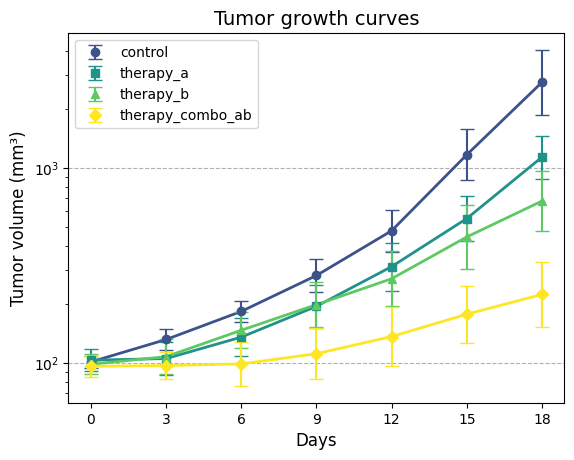

In [37]:
plot_tgi_stats(TGI_stats, ln_scale=True, colormap='viridis')

##### The mathematics behing MEMs

The mixed effects model for exponential growth is represented as:

$${y}_{it}^{\ast }={\sum}_{j=1}^J\left[\left({\alpha}_j+{\omega}_{ij}\right)+\left({\beta}_j+{\varphi}_{ij}\right){t}_{ij}\right]{I}_{ij}+{\Sigma}_{it}$$

where:

- $\stackrel{*}{y_{it}}$: log-transformed tumor volume for animal $i$ at time $t$.
- $t_{ij}$: time of measurement for animal $i$ in group $j$.
- $\alpha_j$: intercept (initial tumor volume) for treatment group $j$.
- $\omega_{ij}$: random intercept deviation for animal $i$ in group $j$.
- $\beta_j$: slope (growth rate) for treatment group $j$.
- $\varphi_{ij}$: random slope deviation for animal $i$ in group $j$.
- $I_{ij}$: indicator variable ($1$ if animal $i$ is in group $j$, $0$ otherwise).
- ${\Sigma}_{it}$: residual error term.

###### Random effects: capturing individual animal variations

The random intercept ($\omega$) represents the _baseline differences_ in tumor volume _between_ individual animals within the same treatment group. Some animals might naturally have larger or smaller tumors at the start, regardless of the treatment. The random slope ($\varphi$) represents the _individual differences_ in tumor growth rates _within_ the same treatment group. Some animals might naturally have faster or slower growing tumors than others in their group.

The **variance-covariance** matrix $\boldsymbol{G}$ describes the relationships between these random effects $\boldsymbol{G}=\left[\begin{array}{cc}{\sigma}_{\omega}^2& {\sigma}_{\omega \varphi}^2\\ {}{\sigma}_{\omega \varphi}^2& {\sigma}_{\varphi}^2\end{array}\right]$, where ${\sigma}_{\omega}^2$ is the variance of the random intercepts (between-animal variability in initial tumor volume), ${\sigma}_{\varphi}^2$ is the variance of the random slopes (between-animal variability in growth rate), and ${\sigma}_{\omega \varphi}^2$ is the covariance between random intercepts and slopes. This captures whether animals with larger initial tumors tend to have faster or slower growth rates.

###### Between-animal vs. within-animal variation

The **between-animal variation** is the variation in tumor growth between different animals within the same treatment group. It's captured by the random effects and their variance-covariance matrix ($\boldsymbol{G}$). The **within-animal variation** is the variation in tumor growth within the same animal over time. It's captured by the residual error term (${\Sigma}_{it}$). In the context of the mixed effects model for tumor growth, the residual error term captures the variability in tumor volume that is not explained by the fixed effects (treatment group effects) or the random effects (individual animal deviations). Specifically, ${\Sigma}_{it}$ might be modeled as a combination of:
1. Measurement error: the inherent variability in measuring tumor volume, which could be due to the limitations of the measurement technique or biological factors.
2. Within-animal variability: the natural fluctuations in tumor growth over time within an individual animal that are not captured by the overall growth trend.

###### Advantages of MEMs

Mixed effects models are particularly well-suited for analyzing longitudinal TGI data because they:

- Account for correlation: they explicitly model the correlation between repeated measurements on the same animal, recognizing that these measurements are not independent.
- Increased efficiency: by accounting for within-animal variability, they can estimate the treatment effects more efficiently, potentially leading to higher statistical power.
- Population-level inference: unlike fixed effects models, mixed effects models allow us to make inferences about the larger population of animals, not just the specific individuals in the study.
- Handling missing data: they can handle missing data points more robustly than traditional repeated measures ANOVA, as long as the missingness is random.

##### Estimating TGR with MEMs with Python

###### Statistical distributions

R's `nlme::lme` function uses t-tests to assess the significance of the fixed effects, particularly when the sample size is relatively small or when the degrees of freedom for the denominator of the test statistic are not well-defined. The t-distribution is appropriate in these cases because it accounts for the uncertainty in estimating the standard error of the fixed effects. R often defaults to reporting t-values in model summaries, even if the sample size is large enough that a z-test would be appropriate. This is likely due to historical reasons and the common practice of using t-tests for small samples.

Statsmodels' `mixedlm`, on the other hand, [tends to use z-tests](https://github.com/statsmodels/statsmodels/issues/2620) (based on the standard normal distribution) to assess the significance of the fixed effects. This is often a _reasonable approximation_ when the sample size is large, and the degrees of freedom for the denominator are well-estimated. Statsmodels generally favors reporting z-values in model summaries, as it assumes that you are often working with larger sample sizes where the z-test is a suitable approximation.

While the test statistics (t-values vs. z-values) might differ slightly, the interpretation of the results remains similar. The P-values associated with these test statistics can be used to assess the statistical significance of the fixed effects in both cases. If the sample size is small, the t-distribution might be a more appropriate choice. We could consider [calculating the degrees of freedom]() and use t-distribution table (or Python's scipy.stats module) to obtain more accurate p-values. If the sample size is large, [the difference between t-values and z-values will be negligible](https://sbwiecko.github.io/intuitive_biostatistics/12%20-%20Confidence%20Interval%20of%20a%20Mean.html#critical-z-vs-t-values). In most practical cases, the difference in results is negligible.

In the mixed-effects model used for TGR analysis, the degrees of freedom are calculated based on the number of animals (groups) and the number of time points. Since we typically have multiple time points, this often results in a relatively high number of residual degrees of freedom. For example, in a study with one treatment group and one control group with 6 animals per group, and 6 time-points analyzed, the degrees of freedom exceed 30.

If the number of animals and/or time points is very small, or in some complex mixed-effects models where the exact degrees of freedom might not be easily determined, using the t-distribution can be a more conservative approach in such cases.

###### The interaction effect

In the model, the formula `log_tv ~ C(group, Treatment(reference='control')) * day` specifies a model with 'C(group, Treatment(reference='control'))' which represents the effect of each treatment group (excluding the reference group, "Control") on the log tumor volume, i.e., the **main effects**, and '* day' the interaction term which models how the effect of each treatment group changes over time, i.e., the **interaction effect**.

The main effect coefficient for 'C(group, Treatment(reference='control'))[T.therapy_xx]' only captures the _average difference_ in tumor growth rate between the "therapy_xx" group and the control group across all time points. However, the treatment effect might not be constant over time; it could increase or decrease as the study progresses.

In a TGR analysis, we're interested in the _rate of change of tumor volume over time_, not just the overall difference at a specific time point. The interaction term `group:day` captures this rate of change (**slope**) for each treatment group relative to the control group. Therefore, by extracting the coefficient from 'C(group, Treatment(reference='control'))[T.therapy_xx]:day', we're getting the _estimated difference in the tumor growth rate_ between the "therapy_xx" group and the "control" group, i.e., the TGR value. Let's say the coefficient for the interaction term is -0.05. This means that, on average, for each additional day in the study, the "therapy_xx" group's log tumor volume is estimated to be 0.05 units lower than what would be expected based on the control group's growth rate and the overall treatment effect of "therapy_xx.", in other words, the therapy's effectiveness in reducing tumor growth increases over time compared to the control group.

In [38]:
import warnings

from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)
# These are warnings that we show as a way of alerting you that we may be in a non-standard situation. Most likely, one of
# the variance parameters is converging to zero. If we get a model result and the parameter estimates and standard errors are
# finite, we can just use them and ignore all the warnings. Note that inference for variance parameters is not meaningful when
# the point estimate is at or near zero.


def tumor_growth_curves_exponential(
    dataset: pd.DataFrame,
    treatments_numerator: List[str],
    treatment_denominator: str = 'control',
    time_points: List[int] = None,
    p_tails: int = 1
) -> pd.DataFrame:
    """
    Estimates and compares tumor growth rates (TGR) between treatment groups using a linear mixed-effects model.

    Args:
        dataset (pd.DataFrame): DataFrame with columns 'day', 'group', and 'tv' (tumor volume).
        treatments_numerator (List[str]): List of treatment group names.
        treatment_denominator (str, optional): Name of the comparison group. Defaults to 'control'.
        time_points (List[int], optional): List of days at which to calculate TGR. If None, uses all unique days.
        p_tails (int, optional): 1 for one-sided test (tumor reduction vs. control), 2 for two-sided test. Defaults to 1.

    Returns:
        pd.DataFrame: DataFrame containing TGR estimates, confidence intervals, and P-values for each contrast.
    """

    # Filter the dataset for relevant groups and time points
    included_groups = treatments_numerator + [treatment_denominator]

    if not time_points:
        # uses all unique days in the dataset
        time_points = dataset['day'].unique()
    tv_data = dataset[
        (dataset['group'].isin(included_groups))
        &
        (dataset['day'].isin(time_points))
    ].copy()

    # Log-transform tumor volume
    tv_data['log_tv'] = np.log(tv_data['tv'])

    # Convert 'day' to numeric and 'group' to categorical variable (good practice)
    tv_data['day'] = pd.to_numeric(tv_data['day'])
    tv_data['group'] = pd.Categorical(
        tv_data['group'], categories=[treatment_denominator] + treatments_numerator)

    # Fit mixed effects model (similar to lme in R)
    model = smf.mixedlm(
        # equivalent to R formula 'lnTV ~ Group * Day, random = ~ 1 + Day | Animal'
        # log_tv modeled as a function of group, day, and their interaction
        f"log_tv ~ C(group, Treatment(reference='{
            treatment_denominator}'))*day",
        data=tv_data,
        # random effects
        # 'animal' is the grouping variable for the random effects
        groups=tv_data['animal'],
        re_formula='~day',  # including a random slope for day for each animal
        # the mixedlm function automatically includes a random intercept term
    )

    est = model.fit(
        reml=True,  # default
        method=["lbfgs"]
    )

    # Extract model estimates for the interaction terms (group:day)
    # print(est.summary())
    results = est.summary().tables[1]
    # Need to trick a little bit the output
    for col in results.columns:
        results[col] = pd.to_numeric(results[col], errors='coerce')
    # print(results)

    # Results container
    model_estimates_list = []

    for treatment in treatments_numerator:
        # Extract TGI, CI, and P-value for the interaction terms (group:day)
        ix = f"C(group, Treatment(reference='{
            treatment_denominator}'))[T.{treatment}]:day"
        tgr = results.loc[ix, "Coef."]

        # Calculate confidence intervals and P-value
        std_err = results.loc[ix, "Std.Err."]

        if p_tails == 1:
            lb95_tgr = np.nan
            ub95_tgr = results.loc[ix, "Coef."] + norm.ppf(0.95) * std_err
            # Although the t-distribution is used in R
            pvalue = norm.cdf(results.loc[ix, "z"])
        # we just pickup the results from statsmodels as it (normal distribution)
        else:
            lb95_tgr = results.loc[ix, "[0.025"]
            ub95_tgr = results.loc[ix, "0.975]"]
            pvalue = results.loc[ix, "P>|z|"]

        # Create a dataframe of the results for the current treatment
        model_estimates = pd.DataFrame({
            "contrast": [f"{treatment} vs. {treatment_denominator}"],
            "time_window": [f"{tv_data['day'].min()}-{tv_data['day'].max()}"],
            "tgr": [tgr],
            "lb95_tgr": [lb95_tgr],
            "ub95_tgr": [ub95_tgr],
            "pvalue": [pvalue],
        })

        # Append results for this treatment to the list
        model_estimates_list.append(model_estimates)

    # Combine results into a single DataFrame
    return pd.concat(model_estimates_list, ignore_index=True)

###### Examples

In the first example, the analysis aims to assess whether the tumor growth rates (TGR) of three different therapies (A, B, and their combination) are significantly lower than the control group's TGR across multiple time points. We're interested in tumor reduction (negative TGRs) compared to the control, so a one-sided test is appropriate. And we're analyzing the entire time window of the study (days 0 to 18) to capture the full dynamics of tumor growth.

In [39]:
tumor_growth_curves_exponential(
    dataset=TGI_dataset,
    treatments_numerator=['therapy_a', 'therapy_b', 'therapy_combo_ab'],
    treatment_denominator='control',      # default
    time_points=[0, 3, 6, 9, 12, 15, 18],  # default all time-points analyzed
    p_tails=1,                            # default
)

,contrast,time_window,tgr,lb95_tgr,ub95_tgr,pvalue
0,therapy_a vs. control,0-18,-0.046,NaN,-0.022972,3.131057e-04
1,therapy_b vs. control,0-18,-0.071,NaN,-0.047972,6.354270e-08
2,therapy_combo_ab vs. control,0-18,-0.132,NaN,-0.108972,5.629282e-23


The TGR values represent the _estimated average difference_ in the growth rates of each treatment group compared to the control group. For example, a negative TGR for "therapy_a vs. control" means that 'therapy_a' is associated with slower tumor growth than the control. The P-value tells us the probability of observing a TGR as extreme as (or more extreme than) the one we obtained, assuming the null hypothesis (no difference in growth rates) is true. A smaller P-value (e.g., less than 0.05) suggests that the observed difference is statistically significant and unlikely due to chance. Since this is a one-sided test, we would only focus on negative values of TGR that are significant.

This analysis allows us to see which treatments are significantly more effective than the control group in **slowing down** tumor growth over the entire study duration. We can also compare the relative efficacy of different treatments by looking at their TGR values and confidence intervals.

In the second example, we compare 'therapy_a' to 'therapy_a', focusing on a specific time window (days 9-18). The exponential growth model assuming that the log-transformed tumor volumes increase linearly with time, if this assumption is violated (e.g., due to non-linear growth patterns), the model might not be appropriate, and the results could be misleading. By selecting time points where the linearity assumption holds, we improve the validity of the analysis.

In [40]:
tumor_growth_curves_exponential(
    dataset=TGI_dataset,
    treatments_numerator=['therapy_a'],
    treatment_denominator='therapy_b',
    time_points=[9, 12, 15, 18],
    p_tails=2)

,contrast,time_window,tgr,lb95_tgr,ub95_tgr,pvalue
0,therapy_a vs. therapy_b,9-18,0.056,0.026,0.087,0.0


This analysis aims to answer the question: "is therapy_a non-inferior or superior to therapy_b in terms of tumor growth rate over the selected time window (days 9-18)?". We use a two-sided test because we want to determine if therapy_a is either better or worse than therapy_b, not just if it's better. And by using only time points where the log tumor volumes exhibit relative linearity, we're ensuring that the exponential growth model is a good fit for the data and that the estimated TGRs are reliable.

The TGR estimate of 0.056 indicates that, on average, the tumor growth rate in the 'therapy_a' group is 5.6% higher per day than the tumor growth rate in the 'therapy_b' group over the analyzed time window. This is the difference in the slopes of the log-transformed tumor volume curves between the two groups.

Let's compare this result to the analysis of the entire time windows in the same groups.

In [41]:
tumor_growth_curves_exponential(
    dataset=TGI_dataset,
    treatments_numerator=['therapy_a'],
    treatment_denominator='therapy_b',
    time_points=[0, 3, 6, 9, 12, 15, 18],
    p_tails=2)

,contrast,time_window,tgr,lb95_tgr,ub95_tgr,pvalue
0,therapy_a vs. therapy_b,0-18,0.025,-0.001,0.051,0.057


The exponential growth model assumes that the logarithm of tumor volume increases linearly with time. However, in reality, early tumor growth often doesn't perfectly follow this pattern. There can be a **lag phase** or initial slow growth before the exponential phase kicks in. Including these early time points in the model can:
-Bias the slope estimate: the early, slower growth can pull down the estimated slope of the regression line, making it appear flatter than it actually is during the truly exponential phase. This can underestimate the treatment effect (difference in slopes between groups).
- Increase variability: the early time points might have more variability in tumor volume, which can increase the residual error in the model and reduce statistical power.
- Violate model assumptions: the exponential model assumes that the log-transformed tumor volume is linearly related to time. If this assumption doesn't hold in the early time points, the model fit will be worse, potentially leading to inaccurate estimates and misleading conclusions.

By selecting time points where the log tumor volume appears to be linear (e.g., 6, 9, 12, 15, 18 days in our example), we're focusing the analysis on the period where the exponential growth assumption is more likely to be valid. This can lead to more accurate TGR estimates, reduced variability, and better model fit.

##### Modeling tumor growth with quadratic exponential models

In preclinical TGI studies that run for a moderate duration, a phenomenon known as **tumor growth deceleration** might occur towards the end of the experiment. This means that the tumor growth rate slows down, rather than remaining constant as assumed in the exponential growth model. This deceleration can be attributed to various factors:
- Resource limitations: as tumors grow larger, they might outstrip the available resources in their surrounding environment, such as nutrients and oxygen, leading to slower growth.
- Spatial constraints: the physical space within the animal or the tumor implantation site might limit the tumor's ability to expand further.
- Treatment effects: some treatments might not only inhibit tumor growth but also actively induce tumor regression or cell death, causing a decline in the growth rate.

To account for this deceleration, a more flexible model is needed. The quadratic exponential model is a suitable alternative as it incorporates a term that captures the change in growth rate over time. The model is defined as:

$$E\left({Y}_{it}^{\ast}\right)={\sum}_{j=1}^K\left[{\alpha}_j+{\beta}_j{t}_{ij}+{\gamma}_j{t}_{ij}^2\right]{I}_{ij}$$

where:
- ${Y}_{it}^{\ast}$: log-transformed tumor volume for animal $i$ at time $t$.
- ${\alpha}_j$: intercept (initial tumor volume) for treatment group $j$.
- ${\beta}_j$: initial growth rate for treatment group $j$.
- ${\gamma}_j$: tumor decay rate (TDR) for treatment group $j$, capturing the deceleration effect over time.
- ${t}_{ij}$: time of measurement for animal $i$ in group $j$.
- ${I}_{ij}$: indicator variable ($1$ if animal $i$ is in group $j$, $0$ otherwise).

The quadratic term (${t}_{ij}^2$) allows for modeling a change in growth rate over time. A positive ${\gamma}_j$ implies a decreasing growth rate (deceleration), while a negative ${\gamma}_j$ would indicate an increasing growth rate (acceleration). The longer the experiment, the more pronounced the effect of the quadratic term becomes. This is because the square of the time (${t}_{ij}^2$) becomes larger, leading to a faster deceleration (or acceleration) of tumor growth.

This model can better represent the complex dynamics of tumor growth, where the rate might not be constant throughout the study. And by capturing the deceleration of growth, the model can lead to more accurate estimates of treatment effects compared to a simple exponential model. However, the model is more complex than the simple exponential model, requiring additional parameters (${\gamma}_j$) to be estimated, and the interpretation of the coefficients might be less intuitive, as the growth rate is no longer constant but depends on time.

To simulate the complex, non-linear growth patterns observed in some tumors, the function below creates virtual groups of animals whose tumor volumes evolve according to the quadratic exponential model, a more nuanced approach than simple exponential growth.

In [42]:
def simulate_quad_exp_growth(
    group_name: str,
    duration: int,
    initial_tumor_volume: float,
    group_growth_rate_day_pct: float,
    growth_rate_cv: float,
    group_decay_rate_day_pct: float,
    decay_rate_cv: float,
    residual_cv: float,
    n_animals: int,
    max_tumor_volume: float,
    df=None,
) -> pd.DataFrame:
    """
    Simulates tumor growth data with quadratic exponential growth for a group of animals.

    Args:
        group_name (str): Name of the group (e.g., "control", "therapy_a").
        duration (int): Duration of the study in days.
        initial_tumor_volume (float): Initial tumor volume (mm^3).
        group_growth_rate_day_perc (float): Average daily growth rate of the group (%).
        growth_rate_cv (float): Coefficient of variation for the growth rate within the group.
        group_decay_rate_day_perc (float): Average daily decay rate of the group (%).
        decay_rate_cv (float): Coefficient of variation for the decay rate within the group.
        residual_cv (float): Coefficient of variation for the measurement error.
        n_animals (int): Number of animals in the group.
        max_tumor_volume (float): Maximum allowed tumor volume before removal (mm^3).
        df (int, optional): Degrees of freedom for the t-distribution. If None,
        defaults to n_animals - 1.

    Returns:
        pd.DataFrame: Simulated data with columns: day, animal, group, tv (Tumor Volume).
    """

    # Initialize an empty list to store DataFrames for each animal in the group
    group_data = []

    # Loop over each animal in the group
    for i in range(n_animals):
        # Create an array of time points (days) when measurements are taken, starting from
        # day 0 up to the end of the study (`duration`). Measurements are taken every 3 days.
        days = np.arange(0, duration + 1, 3)

        # Sample individual growth and decay rates
        #
        # growth_rate_individual = np.random.normal(
        #     group_growth_rate_day_pct / 100,
        #     group_growth_rate_day_pct * growth_rate_cv / 100,
        #     len(days) - 1
        # )
        #
        # Since we're simulating tumor growth data, and the sample size is usually small
        # (below 15 animals per group), using the t distribution could be a reasonable choice.
        # It will introduce slightly more variability into the simulated data, reflecting the
        # uncertainty associated with small samples and the stochastic nature of tumor growth.

        # Shift and scale the t-distribution for individual growth rate
        df = n_animals - 1 if df is None else df  # Default df if not provided
        growth_rate_individual = t_dist.rvs(
            df=df,
            loc=group_growth_rate_day_pct / 100,
            scale=group_growth_rate_day_pct * growth_rate_cv / 100,
            size=len(days) - 1
        )

        # Same for the average daily decay rate
        # decay_rate_individual = np.random.normal(
        #     -group_decay_rate_day_pct / 100,  # Note the negative sign for decay
        #     group_decay_rate_day_pct * decay_rate_cv / 100,
        #     len(days) - 1
        # )
        decay_rate_individual = t_dist.rvs(
            df=df,
            loc=-group_decay_rate_day_pct / 100,  # Note the negative sign for decay
            scale=group_decay_rate_day_pct * decay_rate_cv / 100,
            size=len(days) - 1
        )

        # Note: if the growth rates are strictly positive and tend to be right-skewed (some
        # tumors grow much faster than others), the gamma distribution can be a good option.

        # Initialize an empty array to store the tumor volumes over time
        ln_tumor_volume = np.empty(len(days))

        # ln.tumor.volume[1] <- rnorm(n = 1, mean = log(initial.tumor.volume), sd = sqrt(log((residual.cv^2) + 1)))
        ln_tumor_volume[0] = np.random.normal(
            loc=np.log(initial_tumor_volume),
            scale=np.sqrt(np.log(residual_cv**2 + 1))
        )

        # Iterate over time points (days) to simulate tumor growth
        for t in range(1, len(days)):
            ln_tumor_volume[t] = np.random.normal(
                ln_tumor_volume[t - 1] + growth_rate_individual[t - 1] *
                days[t] + decay_rate_individual[t - 1] * days[t]**2,
                np.sqrt(np.log(residual_cv**2 + 1))
            )
            # Considere Gompertz Growth Model that describes sigmoidal growth patterns,
            # which are often observed in tumors.

        # # Transform log-tumor volumes back to the original scale (tumor volumes in mm^3).
        tumor_volume = np.exp(ln_tumor_volume)

        # Find indices where tumor volume exceeds the maximum allowed.
        welfare_missing = np.where(tumor_volume > max_tumor_volume)[0]
        if len(welfare_missing) > 1:
            # Exclude from its first occurrence until the next timepoint for survival .
            tumor_volume[welfare_missing[1:]] = np.nan

        # Create a DataFrame for the current animal's data
        animal_data = pd.DataFrame(
            {
                "day":    days,
                "animal": f"{group_name}_{i + 1}",
                "group":  group_name,
                "tv":     tumor_volume,
            }
        )

        # Add the animal's data to the list of group data
        group_data.append(animal_data)

    # Concatenate all animal dataframes into one for the entire group
    # ignore_index=True resets the index of the resulting DataFrame.
    return pd.concat(group_data, ignore_index=True)

This next dataset models a preclinical study with:
- Four groups
  - control (vehicle)
  - therapy_a (single agent)
  - therapy_b (single agent)
  - therapy_combo_ab (combination)
- Study design
  - 20 animals per group
  - 24-day duration
  - Tumor volume measurements every 3 days
  - 25% coefficient of variation (CV) for measurement error
- Tumor growth dynamics
  - Initial tumor volume: 100 mm³ for all animals
  - Growth rate: each group has a different average daily growth rate (5%, 4.5%, 3.5%, 1% respectively), with 10% CV within each group.
  - Decay rate: each group (except combo therapy) has a different average daily decay rate (0.2%, 0.125%, 0.1%, 0% respectively), also with 10% CV within each group.

In [43]:
# Set a seed for reproducibility
np.random.seed(1234)

# Simulate the vehicle (control) group data
vehicle_group_quad = simulate_quad_exp_growth(
    group_name="control",
    duration=24,
    initial_tumor_volume=100,
    group_growth_rate_day_pct=5,
    growth_rate_cv=0.1,
    group_decay_rate_day_pct=.2,
    decay_rate_cv=0.1,
    residual_cv=0.25,
    n_animals=20,
    max_tumor_volume=4000
)

# Simulate data for the single-agent therapy A group
therapy_a_group_quad = simulate_quad_exp_growth(
    group_name="therapy_a",
    duration=24,
    initial_tumor_volume=100,
    group_growth_rate_day_pct=4.5,
    growth_rate_cv=0.1,
    group_decay_rate_day_pct=0.125,
    decay_rate_cv=0.1,
    residual_cv=0.25,
    n_animals=20,
    max_tumor_volume=4000
)

# Simulate data for the single-agent therapy B group
therapy_b_group_quad = simulate_quad_exp_growth(
    group_name="therapy_b",
    duration=24,
    initial_tumor_volume=100,
    group_growth_rate_day_pct=3.5,
    growth_rate_cv=0.1,
    group_decay_rate_day_pct=0.1,
    decay_rate_cv=0.1,
    residual_cv=0.25,
    n_animals=20,
    max_tumor_volume=4000
)

# Simulate data for the combination therapy A+B group
therapy_ab_group_quad = simulate_quad_exp_growth(
    group_name="therapy_combo_ab",
    duration=24,
    initial_tumor_volume=100,
    group_growth_rate_day_pct=1,
    growth_rate_cv=0.1,
    group_decay_rate_day_pct=0,
    decay_rate_cv=0.1,
    residual_cv=0.25,
    n_animals=20,
    max_tumor_volume=4000
)

# Combine all group data into a single DataFrame
TGI_dataset_quad = pd.concat(
    [
        vehicle_group_quad,
        therapy_a_group_quad,
        therapy_b_group_quad,
        therapy_ab_group_quad
    ],
    ignore_index=True
)

# Let's have a look at the summary statistics dataset structure and values
print(summary_stats_tgi(TGI_dataset_quad).head(18))

    day      group          est        se    lb95_est     ub95_est
0     0    control    91.691684  0.055588   82.226772   102.246077
1     3    control   111.463101  0.062560   98.600641   126.003470
2     6    control   131.565475  0.096492  108.894927   158.955744
3     9    control   169.299692  0.121101  133.528760   214.653276
4    12    control   249.098542  0.130870  192.741077   321.934922
5    15    control   320.900927  0.146368  240.869553   427.523544
6    18    control   414.639052  0.170672  296.752212   579.357244
7    21    control   478.331367  0.208414  317.926447   719.666133
8    24    control   482.961511  0.221178  313.072613   745.040643
9     0  therapy_a   104.284857  0.050122   94.527387   115.049528
10    3  therapy_a   118.469700  0.080468  101.184204   138.708111
11    6  therapy_a   162.688813  0.085912  137.476671   192.524665
12    9  therapy_a   217.878030  0.108315  176.203841   269.408632
13   12  therapy_a   310.574403  0.114910  247.944348   389.02

In [44]:
# For comparison with the R tutorial we can import the original TGI.dataset
TGI_dataset_quad = pd.read_csv("TGI_dataset_quadratic.csv")
TGI_dataset_quad.columns = [col.lower() for col in TGI_dataset_quad.columns]
for col in TGI_dataset_quad.select_dtypes(include='object').columns:
    TGI_dataset_quad[col] = TGI_dataset_quad[col].astype(str).str.lower()
TGI_dataset.head(6)

,day,animal,group,tv
0,0,control_1,control,104.825993
1,3,control_1,control,125.137266
2,6,control_1,control,155.847247
3,9,control_1,control,238.687772
4,12,control_1,control,335.119128
5,15,control_1,control,729.343194


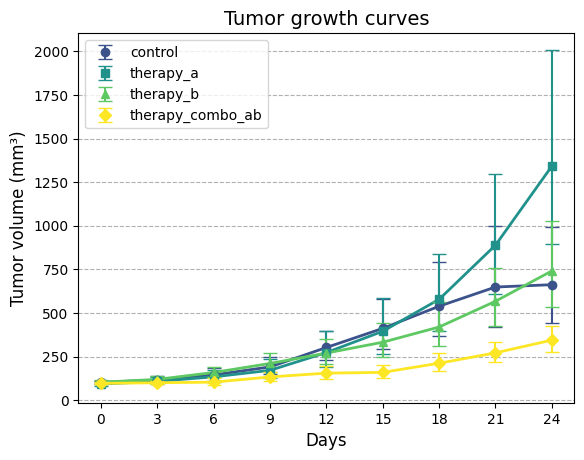

In [45]:
plot_tgi_stats(summary_stats_tgi(TGI_dataset_quad))

##### Analyzing quadratic exponential tumor growth

To accurately analyze this type of tumor growth, we can employ a quadratic exponential model. This model incorporates both a tumor growth rate (TGR) and a **tumor decay rate (TDR)** to capture the non-linear growth dynamics.

The following function estimates and compares the TGR and TDR of different treatment groups against a control group or another treatment group. It allows for both one-sided and two-sided hypothesis tests, providing flexibility for different research questions.

In [46]:
##########################################################################
# THIS FUNCTION DOESN'T GIVE THE SAME RESULTS AS THE ORIGINAL R SNIPPET.
# THOUGH THE R SNIPPET FAILS TO SUMMARIZE PROPERLY THE TGR AND TDR VALUES,
# AS WELL AS THE P VALUES AND THE EXPECTED CONCLUSIONS.
##########################################################################

def tumor_growth_curves_quadratic_exponential(
    dataset: pd.DataFrame,
    treatments_numerator: List[str],
    treatment_denominator: str = 'control',
    time_points: List[int] = None,
    p_tails: int = 1
) -> pd.DataFrame:
    """
    Estimates and compares tumor growth rates (TGR) and tumor decay rates (TDR) between treatment groups using a linear mixed-effects model
    with a quadratic term for time.

    Args:
        dataset (pd.DataFrame): DataFrame with columns 'day', 'group', and 'tv' (tumor volume).
        treatments_numerator (List[str]): List of treatment group names.
        treatment_denominator (str, optional): Name of the comparison group. Defaults to 'control'.
        time_points (List[int], optional): List of days at which to calculate TGR. If None, uses all unique days.
        p_tails (int, optional): 1 for one-sided test (tumor reduction vs. control), 2 for two-sided test. Defaults to 1.

    Returns:
        pd.DataFrame: DataFrame containing TGR and TDR estimates, with their confidence intervals, and P-values for each contrast.
    """

    # Filter the dataset for relevant groups and time points
    included_groups = treatments_numerator + [treatment_denominator]

    if not time_points:
        # uses all unique days in the dataset
        time_points = dataset['day'].unique()
    tv_data = dataset[
        (dataset['group'].isin(included_groups))
        &
        (dataset['day'].isin(time_points))
    ].copy()

    # Log-transform tumor volume
    tv_data['log_tv'] = np.log(tv_data['tv'])

    # Convert 'day' to numeric and 'group' to categorical variable (good practice)
    tv_data['day'] = pd.to_numeric(tv_data['day'])
    tv_data['group'] = pd.Categorical(
        tv_data['group'], categories=[treatment_denominator] + treatments_numerator)

    # Generate orthogonal polynomial features for Day (degree 2)
    poly_features = np.polynomial.polynomial.polyvander(tv_data['day'], deg=2)
    tv_data['day_linear'] = poly_features[:, 1]  # Linear term
    tv_data['day_quadratic'] = poly_features[:, 2]  # Quadratic term

    # Fit a linear mixed-effects model with a quadratic time component and random effects for both intercept and slope
    model = smf.mixedlm(
        # equivalent to R formula 'lnTV ~ Group * poly(Day, 2), random = ~ 1 + poly(Day, 2) | Animal'
        f"log_tv ~ C(group, Treatment(reference='{
            treatment_denominator}')) * (day_linear + day_quadratic)",
        data=tv_data,
        groups=tv_data["animal"],
        re_formula="day_linear + day_quadratic",
        missing='drop')

    est = model.fit(
        reml=True,  # default
        method=["lbfgs"]
    )

    # Extract model estimates for the interaction terms (group:day)
    # print(est.summary())
    results = est.summary().tables[1]
    # Need to trick a little bit the output
    for col in results.columns:
        results[col] = pd.to_numeric(results[col], errors='coerce')

    # Results container
    model_estimates_list = []

    for treatment in treatments_numerator:
        # Extract TGI, TGR, and their CI, and P-value related to the interaction terms with
        # the quadratic day component ('poly(day, 2)')
        ix_tgr = f"C(group, Treatment(reference='{treatment_denominator}'))[T.{
            treatment}]:day_linear"
        ix_tdr = f"C(group, Treatment(reference='{treatment_denominator}'))[T.{
            treatment}]:day_quadratic"

        tgr = results.loc[ix_tgr, "Coef."]
        tdr = results.loc[ix_tdr, "Coef."]

        # Calculate confidence intervals and P-values for TGR and TDR
        std_err_tgr = results.loc[ix_tgr, "Std.Err."]
        std_err_tdr = results.loc[ix_tdr, "Std.Err."]

        if p_tails == 1:
            lb95_tgr = np.nan
            ub95_tgr = results.loc[ix_tgr, "Coef."] + \
                norm.ppf(0.95) * std_err_tgr
            # Although the t-distribution is used in R
            pvalue_tgr = norm.cdf(results.loc[ix_tgr, "z"])
            lb95_tdr = np.nan
            ub95_tdr = results.loc[ix_tdr, "Coef."] + \
                norm.ppf(0.95) * std_err_tdr
            # Although the t-distribution is used in R
            pvalue_tdr = norm.cdf(results.loc[ix_tdr, "z"])

        # we just pickup the results from statsmodels as it (normal distribution)
        else:
            lb95_tgr = results.loc[ix_tgr, "[0.025"]
            ub95_tgr = results.loc[ix_tgr, "0.975]"]
            pvalue_tgr = results.loc[ix_tgr, "P>|z|"]
            lb95_tdr = results.loc[ix_tdr, "[0.025"]
            ub95_tdr = results.loc[ix_tgr, "0.975]"]
            pvalue_tdr = results.loc[ix_tdr, "P>|z|"]

        # Create a dataframe of the results for the current treatment
        model_estimates = pd.DataFrame({
            "contrast": [f"{treatment} vs. {treatment_denominator}"],
            "time_window": [f"{tv_data['day'].min()}-{tv_data['day'].max()}"],
            "tgr": [tgr],
            "lb95_tgr": [lb95_tgr],
            "ub95_tgr": [ub95_tgr],
            "pvalue_tgr": [pvalue_tgr],
            "tdr": [tdr],
            "lb95_tdr": [lb95_tdr],
            "ub95_tdr": [ub95_tdr],
            "pvalue_tdr": [pvalue_tdr],
        })

        # Append results for this treatment to the list
        model_estimates_list.append(model_estimates)

    # Combine results into a single DataFrame
    return pd.concat(model_estimates_list, ignore_index=True)

In [47]:
tumor_growth_curves_quadratic_exponential(
    TGI_dataset_quad,
    treatments_numerator=['therapy_a'],
)

,contrast,time_window,tgr,lb95_tgr,ub95_tgr,pvalue_tgr,tdr,lb95_tdr,ub95_tdr,pvalue_tdr
0,therapy_a vs. control,0-24,-0.042,NaN,-0.015682,0.004607,0.003,NaN,0.047411,0.542209


In [48]:
tumor_growth_curves_quadratic_exponential(
    TGI_dataset_quad,
    treatments_numerator=['therapy_a'],
    p_tails=2
)

,contrast,time_window,tgr,lb95_tgr,ub95_tgr,pvalue_tgr,tdr,lb95_tdr,ub95_tdr,pvalue_tdr
0,therapy_a vs. control,0-24,-0.042,-0.073,-0.01,0.009,0.003,-0.049,-0.01,0.916


The discrepancies in intercept, TGR, and TDR values between R's `lme` and Python's `statsmodels.mixedlm` can be attributed to several factors:
1. Differences in estimation algorithms:
   - R (lme): the `lme` function in the `nlme` package typically uses Restricted Maximum Likelihood (REML) as the default estimation method for mixed-effects models. REML aims to provide unbiased estimates of the variance components (the random effects).
   - Python (statsmodels): The `mixedlm` function in `statsmodels` also uses REML as a default method. However, there might be subtle differences in the specific algorithms and optimizations used in each library, leading to slightly different estimates.
2. Differences in default settings:
   - Convergence criteria: the convergence criteria for the iterative optimization algorithms used to fit the models might differ between the two libraries. This could lead to slightly different stopping points and therefore different estimates.
   - Parameterization of random effects: the way the random effects are parameterized and the default assumptions about their distribution (e.g., unstructured vs. diagonal covariance matrix) might also vary slightly, contributing to the differences.
3. Numerical precision:
   - The underlying numerical libraries and calculations used by R and Python might have slight differences in precision, which can accumulate and lead to small variations in the final estimates.

Interpreting the results:
- Intercept: the intercept represents the baseline log-transformed tumor volume for the reference group at day 0. The difference between the R and Python estimates (e.g., 5.622 vs. 4.493) suggests a slight shift in the baseline level between the two models.
- TGR: the TGR represents the average change in log tumor volume per day for each group. The discrepancy between R (3.8543) and Python (-0.042) is more substantial. This might indicate a difference in how the models are estimating the time-dependent effect of the treatment.
- TDR: the TDR represents the acceleration or deceleration in the growth rate over time. Again, the difference between R (2.81) and Python (0.003) suggests some variation in how the quadratic term is being estimated by the two models.

While the exact numerical values might differ, the overall conclusions about the relative effects of the treatments should be consistent between the two implementations.
The statistical significance of the treatment effects (as indicated by p-values) should also be similar, although minor differences are possible due to the variations in degrees of freedom and estimation methods.

Remember that the goal is to understand the relative differences between groups, not to obsess over minor numerical discrepancies. If the qualitative conclusions are similar between R and Python, then we can be reasonably confident in the findings.

##### Modeling long-term tumor dynamics with the Gompertzian model

While exponential and quadratic exponential models are useful for capturing tumor growth patterns over shorter periods, they have a key limitation: they predict unlimited growth. However, long-term experiments reveal that tumor growth doesn't continue indefinitely. It eventually plateaus due to factors like limited resources and space constraints within the body.

The [Gompertzian model addresses this limitation](https://www.tmlep.com/clinical-learning/2023-01-23-when-did-this-tumour-start-the-need-for-a-gompertzian-understanding-of-tumour-growth-kinetics) by introducing a **theoretical upper limit** ($y_\text{max}$) to tumor volume. This means that the model predicts tumor growth will slow down and eventually stop as it approaches this maximum size, more accurately reflecting real-world observations.

The Gompertzian model is applied to a transformed version of the tumor volume data, i.e., ${y}_{it}^{\dagger }=\ln \left(\ln \left({y}_{max}/{y}_{it}\right)\right)$. This _double log-transformation_ linearizes the relationship between tumor growth and time. The model can then be expressed as:

$$E\left({Y}_{it}^{\dagger}\right)={\eta}_j+{t_{ij}}^{\ast }{\lambda}_j$$

where:
- $E\left({Y}_{it}^{\dagger}\right)$: expected value of the double log-transformed tumor volume for animal $i$ at time $t$.
- ${\eta}_j$: a parameter related to the initial tumor volume and growth rate for treatment group $j$.
- ${\lambda}_j$: the **Gompertzian force** for treatment group $j$, which determines the rate at which tumor growth slows down.
- ${t_{ij}}^{\ast }$: time of measurement for animal $i$ in group $j$.

The ${\eta}_j$ parameter combines information about the initial tumor volume ($\alpha_j$) and the initial growth rate ($\beta_j$) for group $j$, i.e., ${\eta}_j=\ln \left({\beta}_j/{\alpha}_j\right)$. A higher ${\eta}_j$ indicates a larger initial tumor or faster initial growth.

${\lambda}_j$ is the key parameter in the Gompertzian model. It represents the "force of mortality" or the rate at which the tumor's growth potential decreases over time. A larger positive value of ${\lambda}_j$ means the tumor growth slows down more quickly, and when ${\lambda}_j$ approaches zero, the Gompertzian model reduces to the exponential growth model, indicating constant growth.

Finally, the growth rate at any given time can be calculated as ${\beta_j}^{\ast}\mathit{\exp}\left({t_{ij}}^{\ast }{\lambda}_j\right)$. This shows that the growth rate decreases exponentially over time due to the Gompertzian force.

The Gompertzian model requires knowledge of the maximum tumor volume ($y_\text{max}$), which can only be estimated accurately by allowing tumors to grow for extended periods until they reach a plateau. This raises _ethical concerns_ about animal welfare, as it can lead to prolonged suffering.

The Gompertzian model provides a more realistic representation of tumor growth compared to the exponential or quadratic exponential models, especially for long-term studies. It incorporates the concept of a _carrying capacity_, which represents the maximum tumor volume achievable due to biological constraints. We'll simulate data following this model while using log-normal distribution for individual tumor volumes to introduce realistic variability. In contrast to shorter-term studies where animal welfare considerations might limit tumor size, the goal of this simulation is to explore the theoretical long-term dynamics of tumor growth under different treatment conditions. Therefore, we won't be implementing the concept of "welfare missing," as we're interested in observing how tumor volumes evolve over an extended period, even if they exceed what would be ethically permissible in a real animal study.

In [49]:
def simulate_gompertz_growth(
        group_name: str,
        duration: int,
        initial_tumor_volume: float,
        maximum_tumor_volume: float,
        group_growth_rate_day_pct: float,
        growth_rate_cv: float,
        residual_cv: float,
        n_animals: int,
        df=None
) -> pd.DataFrame:
    """
    Simulates tumor growth data for a group of animals over a given duration, using the Gompertzian model 
    with log-normal error.

    Args:
        group_name (str): Name of the group (e.g., "control", "therapy_a").
        duration (int): Duration of the study in days.
        initial_tumor_volume (float): Initial tumor volume (mm^3).
        maximum_tumor_volume (float): Maximum theoretical tumor volume (mm^3).
        group_growth_rate_day_pct (float): Average initial daily growth rate of the group (%).
        growth_rate_cv (float): Coefficient of variation for the growth rate within the group.
        residual_cv (float): Coefficient of variation for the measurement error.
        n_animals (int): Number of animals in the group.
        df (int, optional): Degrees of freedom for the t-distribution (growth rate variation). If None, 
        defaults to n_animals - 1.

    Returns:
        pd.DataFrame: Simulated data with columns: day, animal, group, tv (Tumor Volume).
    """

    group_data = []

    for i in range(n_animals):
        days = np.arange(0, duration + 1, 3)

        # Sample individual growth rates from a t-distribution
        df = n_animals - 1 if df is None else df

        # growth.rate.individual <- rnorm(n = (length(days) - 1), mean = group.growth.rate.day.perc / 100,
        # sd = group.growth.rate.day.perc * growth.rate.cv / 100)
        growth_rate_individual = t_dist.rvs(
            df=df,
            loc=group_growth_rate_day_pct / 100,
            scale=group_growth_rate_day_pct * growth_rate_cv / 100,
            size=len(days) - 1
        )

        # Calculate carrying capacity on the log scale (log of maximum tumor volume)
        carrying_capacity = np.log(maximum_tumor_volume)

        ln_tumor_volume = np.empty(len(days))
        # Day 0 simulation using normal distribution
        # ln.tumor.volume[1] <- rnorm(n = 1, mean = log(initial.tumor.volume), sd = sqrt(log((residual.cv^2) + 1)))
        ln_tumor_volume[0] = np.random.normal(
            loc=np.log(initial_tumor_volume),
            scale=np.sqrt(np.log(residual_cv**2 + 1))
        )

        # Simulate tumor volumes using the Gompertzian growth equation
        for t in range(1, len(days)):
            # growth.term <- (ln.tumor.volume[1] - carrying.capacity) * exp(-growth.rate.individual[t - 1] * days[t])
            # ln.tumor.volume[t] <- rnorm(n = 1, mean = carrying.capacity + growth.term, sd = sqrt(log((residual.cv^2) + 1)))
            # Calculate mean and standard deviation of the underlying normal distribution for log-normal
            growth_term = (ln_tumor_volume[0] - carrying_capacity) * \
                np.exp(-growth_rate_individual[t-1] * days[t])

            ln_tumor_volume[t] = np.random.normal(
                loc=carrying_capacity + growth_term,
                scale=np.sqrt(np.log(residual_cv**2 + 1)),
            )

        # Store the data for the current animal in a DataFrame
        animal_data = pd.DataFrame({
            "day": days,
            "animal": f"{group_name}_{i + 1}",
            "group": group_name,
            # Retrieve the tumor volume in linear scale
            "tv": np.exp(ln_tumor_volume),
        })
        group_data.append(animal_data)
    # Combine all animal dataframes into one for the entire group.
    return pd.concat(group_data, ignore_index=True)

The simulated dataset will be created with the following characteristics:

- Four groups:
  - Control (vehicle)
  - therapy_a (single agent)
  - therapy_b (single agent)
  - therapy_combo_ab (combination)
- Study design:
  - 20 animals per group
  - 60-day duration
  - Tumor volume measurements every 3 days
  - 25% coefficient of variation (CV) for measurement error
- Tumor growth dynamics:
  - Initial tumor volume: 100 mm³ for all animals
  - Maximum tumor volume: 6000 mm³ (theoretical limit)
  - Growth rate: Each group has a different average daily growth rate (6%, 4%, 3%, 2% respectively), with 10% CV within each group

In [50]:
# Set random seed for reproducibility
np.random.seed(1)

# Simulate the control group (Vehicle) data
control = simulate_gompertz_growth(
    group_name="control",
    duration=60,
    initial_tumor_volume=100,
    maximum_tumor_volume=6000,
    group_growth_rate_day_pct=6,
    growth_rate_cv=0.1,
    residual_cv=0.25,
    n_animals=20,
)

# Simulate data for Therapy_A group
therapy_a = simulate_gompertz_growth(
    group_name="therapy_a",
    duration=60,
    initial_tumor_volume=100,
    maximum_tumor_volume=6000,
    group_growth_rate_day_pct=4,
    growth_rate_cv=0.1,
    residual_cv=0.25,
    n_animals=20,
)

# Simulate data for Therapy_B group
therapy_b = simulate_gompertz_growth(
    group_name="therapy_b",
    duration=60,
    initial_tumor_volume=100,
    maximum_tumor_volume=6000,
    group_growth_rate_day_pct=3,
    growth_rate_cv=0.1,
    residual_cv=0.25,
    n_animals=20,
)

# Simulate data for Therapy_Combo_AB group
therapy_combo_ab = simulate_gompertz_growth(
    group_name="therapy_combo_ab",
    duration=60,
    initial_tumor_volume=100,
    maximum_tumor_volume=6000,
    group_growth_rate_day_pct=2,
    growth_rate_cv=0.1,
    residual_cv=0.25,
    n_animals=20,
)

# Combine all group data into a single DataFrame
TGI_dataset_gompertz = pd.concat(
    [control, therapy_a, therapy_b, therapy_combo_ab], ignore_index=True
)

TGI_dataset_gompertz.head(6)

,day,animal,group,tv
0,0,control_1,control,107.670789
1,3,control_1,control,213.533876
2,6,control_1,control,250.344526
3,9,control_1,control,486.383178
4,12,control_1,control,593.092860
5,15,control_1,control,1420.028888


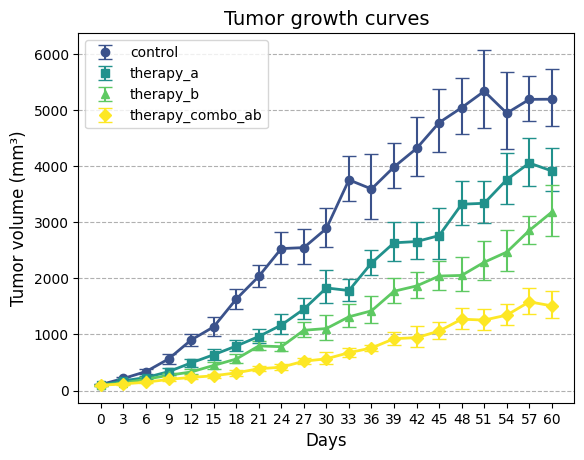

In [51]:
plot_tgi_stats(summary_stats_tgi(TGI_dataset_gompertz))

In [52]:
# For comparison with the R tutorial we can import the original TGI.dataset
TGI_dataset_gompertz = pd.read_csv("TGI_dataset_gompertz.csv")
TGI_dataset_gompertz.columns = [col.lower()
                                for col in TGI_dataset_gompertz.columns]
for col in TGI_dataset_gompertz.select_dtypes(include='object').columns:
    TGI_dataset_gompertz[col] = TGI_dataset_gompertz[col].astype(
        str).str.lower()
TGI_dataset.head(6)

,day,animal,group,tv
0,0,control_1,control,104.825993
1,3,control_1,control,125.137266
2,6,control_1,control,155.847247
3,9,control_1,control,238.687772
4,12,control_1,control,335.119128
5,15,control_1,control,729.343194


##### Long-term TGI studies and the Gompertzian model

As we discussed earlier, the Gompertzian model is well-suited for analyzing long-term tumor growth inhibition (TGI) studies where tumors might reach a plateau due to factors like limited resources or space. In this model, we transform the tumor volume data using the following equation ${y}_{ij k}^{\dagger }=\ln \left(\ln \left({y}_{max}/{y}_{ij k}\right)\right)$, where ${y}_{max}$ is the maximum tumor volume (carrying capacity), and ${y}_{ij k}$ is the observed tumor volume for animal $i$ in group $j$ at time $k$. This transformation makes the relationship between the transformed tumor volume (${y}_{ij k}$) and time approximately linear, allowing us to use a linear mixed-effects model for analysis.

The following formula defines a mixed-effects model to analyze tumor growth rates (TGRs) in a longitudinal TGI study, assuming that the tumor growth follows a Gompertzian pattern:

$$E\left({y}_{ij k}^{\dagger}\right)=\left({\eta}_j+{n}_{ij}\right)+\left({\lambda}_j+{l}_{ij}\right)\ast {t}_{ij k}$$

Let's break down each component of this equation:
- $E\left({y}_{ij k}^{\dagger}\right)$: this represents the _expected value (average)_ of the transformed tumor volume (${y}_{ij k}^{\dagger}$) for animal $i$ in group $j$ at the $k$-th time point. The dagger ($^{\dagger}$) symbol indicates the transformation of the original tumor volume ($y$) using the Gompertzian formula.
- ${\eta}_j$: this is the fixed effect for the intercept of the $j$-th group. It represents the average initial transformed tumor volume for animals in group $j$ at the beginning of the study ($t=0$).
- ${n}_{ij}$: this is the random effect for the intercept, capturing individual variations in the initial transformed tumor volume among animals within the same group. It's assumed to be normally distributed with a mean of 0.
- ${\lambda}_j$: this is the fixed effect for the slope of the $j$-th group. It represents the average rate of change of the transformed tumor volume over time for animals in group $j$ (the Gompertzian force).
- ${l}_{ij}$: this is the random effect for the slope, accounting for individual variations in the tumor growth rate among animals within the same group. It's assumed to be normally distributed with a mean of 0.
- ${t}_{ij k}$: this is the time point of the $k$-th measurement for animal $i$ in group $j$.

How to interpret these terms?
- Fixed effects (${\eta}_j$, ${\lambda}_j$): these parameters capture the average initial transformed tumor volume and the average growth rate for each treatment group, respectively. By comparing these estimates across groups, we can assess the effects of different treatments on tumor growth dynamics.
- Random effects (${n}_{ij}$, ${l}_{ij}$): these parameters account for the variability in the initial tumor volume and growth rate among individual animals within each group. The mixed-effects model framework allows the estimatation of these random effects and their variance components, providing a more comprehensive understanding of the variability in tumor growth patterns.

We can implement this model in Python using the `statsmodels.formula.api.mixedlm` function, similar to how we did for the exponential model. The formula would be adapted to use the Gompertz-transformed outcome variable and the random effects structure.

In [53]:
def tumor_growth_curves_gompertzian(
    dataset: pd.DataFrame,
    treatments_numerator: List[str],
    treatment_denominator: str = 'control',
    p_tails: int = 1
) -> pd.DataFrame:
    """
    Estimates and compares Gompertzian parameters (lambda) between treatment groups using a linear mixed-effects model.

    Args:
        dataset (pd.DataFrame): DataFrame with columns 'day', 'group', 'animal', and 'tv' (tumor volume).
        treatments_numerator (List[str]): List of treatment group names (numerator in the comparison).
        treatment_denominator (str, optional): Name of the comparison group (denominator). Defaults to 'control'.
        p_tails (int, optional): 1 for one-sided test (tumor reduction), 2 for two-sided test. Defaults to 1.

    Returns:
        pd.DataFrame: DataFrame containing Gompertzian parameter estimates, confidence intervals, and p-values for each contrast.
    """

    # Filter the dataset for relevant groups and time points
    included_groups = treatments_numerator + [treatment_denominator]
    tv_data = dataset[dataset['group'].isin(included_groups)].copy()

    # Create Gompertz transformed variable
    # Pseudocount to avoid division by zero
    espilon = 1e-8
    tv_data["y_cross"] = np.log(
        np.log(tv_data['tv'].max() / (tv_data['tv'] + epsilon) + epsilon))
    # Handle undefined values (-inf) by replacing them with a very small negative number
    # tv_data["y_cross"] = tv_data["y_cross"].replace(-np.inf, tv_data["y_cross"][np.isfinite(tv_data["y_cross"])].min())
    tv_data["y_cross"] = tv_data["y_cross"].replace(-np.inf, espilon)

    # # Ensure 'Day' is numeric and convert 'group' to categorical variable (good practice)
    tv_data['day'] = pd.to_numeric(tv_data['day'])
    tv_data['group'] = pd.Categorical(
        tv_data['group'], categories=[treatment_denominator] + treatments_numerator)

    # Fit a linear mixed-effects model
    model = smf.mixedlm(
        # equivalent to R formula 'y.cross ~ Group * Day, random = ~ 1 + Day | Animal'
        f"y_cross ~ C(group, Treatment(reference='{
            treatment_denominator}')) * day",
        data=tv_data,
        groups=tv_data["animal"],
        re_formula="day",
        missing='drop')

    est = model.fit(
        reml=True,  # default
        # method=["lbfgs"]
    )

    # Extract model estimates for the interaction terms (group:day)
    # print(est.summary())
    results = est.summary().tables[1]
    # Need to trick a little bit the output
    for col in results.columns:
        results[col] = pd.to_numeric(results[col], errors='coerce')

    # Results container
    model_estimates_list = []

    for treatment in treatments_numerator:
        # Extract model estimates
        ix = f"C(group, Treatment(reference='{
            treatment_denominator}'))[T.{treatment}]:day"

        Gompertz_par = results.loc[ix, "Coef."]

        # Calculate confidence intervals and P-values for TGR and TDR
        std_err = results.loc[ix, "Std.Err."]

        if p_tails == 1:
            lb95 = np.nan
            ub95 = Gompertz_par + norm.ppf(0.95) * std_err
            # Although the t-distribution is used in R
            pvalue = 1 - norm.cdf(results.loc[ix, "z"])

        # we just pickup the results from statsmodels as it (normal distribution)
        else:
            lb95 = results.loc[ix, "[0.025"]
            ub95 = results.loc[ix, "0.975]"]
            pvalue = results.loc[ix, "P>|z|"]

        # Create a dataframe of the results for the current treatment
        model_estimates = pd.DataFrame({
            "contrast": [f"{treatment} vs. {treatment_denominator}"],
            "Gompertz_par": [Gompertz_par],
            "lb95": [lb95],
            "ub95": [ub95],
            "pvalue": [pvalue],
        })

        # Append results for this treatment to the list
        model_estimates_list.append(model_estimates)

    # Combine results into a single DataFrame
    return pd.concat(model_estimates_list, ignore_index=True)

In [54]:
tumor_growth_curves_gompertzian(TGI_dataset_gompertz, treatments_numerator=[
                                'therapy_a', 'therapy_b', 'therapy_combo_ab'])

,contrast,Gompertz_par,lb95,ub95,pvalue
0,therapy_a vs. control,0.010,NaN,0.014935,1.293395e-03
1,therapy_b vs. control,0.016,NaN,0.020935,8.215281e-07
2,therapy_combo_ab vs. control,0.023,NaN,0.027935,8.779644e-12


In [55]:
tumor_growth_curves_gompertzian(TGI_dataset_gompertz, treatments_numerator=[
                                'therapy_a'], treatment_denominator='control', p_tails=2)

,contrast,Gompertz_par,lb95,ub95,pvalue
0,therapy_a vs. control,0.01,0.002,0.019,0.02


The Gompertzian parameter (often denoted as $\lambda$) represents the rate at which tumor growth slows down over time.  A positive 'Gompertz.par' of 0.01 indicates that 'therapy_a' is associated with a slightly higher rate of tumor growth deceleration compared to the control group. In other words, tumors in the 'therapy_a' group are slowing down in their growth rate a bit faster than those in the control group.

The magnitude of 0.01 suggests that the difference in deceleration rates is relatively small. It's essential to interpret this in the context of the specific units of time used in the study (e.g., days, weeks) and the overall range of Gompertzian parameters observed in the data. The interpretation also depends on whether this difference is statistically significant. If the associated P-value is small (e.g., less than 0.05), it suggests that the observed difference is unlikely to be due to chance alone, and 'therapy_a' likely has a true effect on tumor growth deceleration.

The 'Gompertz.par' value alone doesn't tell us the absolute growth rates or tumor sizes in each group. It only represents the difference in the rate of change of the growth rates.
To fully understand the impact of the treatment, we would also need to look at the estimated TGR (Tumor Growth Rate) and the actual tumor volumes over time for both groups.
The biological interpretation of the Gompertzian force depends on the specific context of the study and the tumor type we're investigating.

##### Summarizing tumor growth with AUC

When analyzing longitudinal tumor growth data, one way to condense the information from multiple time points is to calculate the **Area Under the Curve (AUC)** for each animal's growth trajectory. The AUC represents the cumulative effect of tumor growth over time, providing a single value for each animal that can be used for statistical comparisons between groups.

Why use log-transformed values (${y}_{ijt}^{\ast }$)?
1. _Balancing early and late time points_: in tumor growth curves, early time points often show rapid growth, while later time points may show slower growth or even a plateau. Using the raw tumor volumes (${y}_{ijt}^{\ast }$) for AUC calculation can give undue weight to these early rapid growth phases. Log-transforming the values (${y}_{ijt}^{\ast }$ = ln({y}_{ijt}))$ helps to balance the influence of early and late time points, ensuring a more even contribution across the study period.
2. _Standardizing to zero_: subtracting the initial log-transformed tumor volume (${y}_{ij1}^{\ast }$) from all subsequent values for the same animal standardizes the growth curves to start at zero. This focuses the AUC analysis on the change in tumor growth over time rather than absolute tumor volumes, which can vary between animals even within the same group.

While various methods exist for calculating AUC, the **trapezoidal rule** is the most commonly used due to its simplicity and ease of implementation. It approximates the area under the curve by dividing it into trapezoids and summing their areas, with $\text{AUC}_{t_1 - t_2} \approx \sum[1/2 * ({y}_{ijt_1}^{\ast } + {y}_{ijt_2}^{\ast }) * (t_2 - t_1)]$.

Once we have calculated the AUC values for each animal, you can treat these values as your outcome variable and perform standard statistical tests like t-tests (for two groups) or ANOVA (for multiple groups) to compare the average AUC between treatment and control groups. This tells us if there's a statistically significant difference in the overall tumor growth pattern over time.

##### AUC analysis with Python

In addition to examining specific time points or growth rates, analyzing the area under the curve (AUC) of tumor growth curves provides a holistic view of the overall tumor burden over time.  The AUC summarizes the cumulative effect of treatment across the entire study period, offering a complementary perspective to TGR analysis.

The following function, `tumor_auc`, calculates and compares the AUC of different treatment groups, providing a comprehensive assessment of treatment efficacy in inhibiting tumor growth.

In [193]:
from scipy.integrate import trapezoid as trapz
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.trapezoid.html


def tumor_auc(
    dataset: pd.DataFrame,
    treatments_numerator: List[str],
    treatment_denominator: str = 'control',
    p_tails: int = 1
) -> pd.DataFrame:
    """
    Calculates and compares area under the curve (AUC) of tumor growth curves between treatment groups.

    Args:
        dataset (pd.DataFrame): DataFrame with columns 'day', 'group', 'animal', and 'tv' (tumor volume).
        treatments_numerator (List[str]): List of treatment group names.
        treatment_denominator (str, optional): Name of the comparison group. Defaults to 'control'.
        p_tails (int, optional): 1 for one-sided test (tumor reduction), 2 for two-sided test. Defaults to 1.

    Returns:
        pd.DataFrame: DataFrame with columns 'contrast', 'AUC_diff', 'lb95_AUC_diff', 'ub95_AUC_diff', and 'pvalue'.
    """

    # Filter relevant data
    tv_data = dataset[dataset['group'].isin(
        treatments_numerator + [treatment_denominator])].copy()

    # Log-transform tumor volume (tv) and add log_tv column
    tv_data['log_tv'] = np.log(tv_data['tv'])

    # Extract baseline (first day) data
    tv_data['log_tv_baseline'] = tv_data.groupby(
        'animal')['log_tv'].transform('first')
    # remove baseline from further calculations for standardization, to avoid bias,
    # and focusing on treatment's effect on tumor growth dynamics
    tv_data = tv_data.query('day != day.min()')

    # Calculate height for AUC (subtracting baseline and setting negative values to 0)
    tv_data['height'] = tv_data['log_tv'] - tv_data['log_tv_baseline']
    tv_data['height'] = tv_data['height'].apply(
        lambda x: max(0, x))  # Ensure non-negative heights

    # Calculate AUC for each animal using trapezoidal rule
    def calculate_auc(x):
        x = x.sort_values('day')
        return trapz(x['height'], x['day'])

    auc_data = tv_data.groupby('animal').apply(
        calculate_auc).reset_index(name='AUC')

    # Merge AUC data with original data to get group information
    auc_data = auc_data.merge(
        tv_data[['animal', 'group']], on='animal', how='left').drop_duplicates()

    # Convert group to factor
    auc_data['group'] = pd.Categorical(auc_data['group'], categories=[
                                       treatment_denominator] + treatments_numerator)

    # Fit a linear model to compare AUCs between groups
    model = smf.ols('AUC ~ group', data=auc_data)
    est = model.fit()
    degrees_of_freedom = est.df_resid

    # Extract model estimates for the interaction terms (group:day)
    # print(est.summary2())
    results = est.summary2().tables[1]

    # Results container
    model_estimates_list = []

    for treatment in treatments_numerator:
        # Extract model estimates
        ix = f"group[T.{treatment}]"

        Gompertz_par = results.loc[ix, "Coef."]

        # Calculate confidence intervals and P-values for TGR and TDR
        std_err = results.loc[ix, "Std.Err."]

        if p_tails == 1:
            lb95 = np.nan
            ub95 = Gompertz_par +t_dist.ppf(0.95, df=degrees_of_freedom) * std_err
            pvalue = t_dist.cdf(results.loc[ix, "t"], df=degrees_of_freedom)

        # we just pickup the results from statsmodels as it (normal distribution)
        else:
            lb95 = results.loc[ix, "[0.025"]
            ub95 = results.loc[ix, "0.975]"]
            pvalue = results.loc[ix, "P>|t|"]

        # Create a dataframe of the results for the current treatment
        model_estimates = pd.DataFrame({
            "contrast": [f"{treatment} vs. {treatment_denominator}"],
            "AUC_diff": [Gompertz_par],
            "lb95_AUC_diff": [lb95],
            "ub95_AUC_diff": [ub95],
            "pvalue": [pvalue],
        })

        # Append results for this treatment to the list
        model_estimates_list.append(model_estimates)

    # Combine results into a single DataFrame
    return pd.concat(model_estimates_list, ignore_index=True)

Let's first call `tumor_auc` to compare the overall tumor burden (AUC) of three treatment groups ('therapy_a', 'therapy_b', and 'therapy_combo_ab') to the control group across the entire study duration. The goal is to determine if any of the treatments lead to a statistically significant reduction in tumor burden compared to the control.

In [194]:
tumor_auc(
    dataset=TGI_dataset,
    treatments_numerator=['therapy_a', 'therapy_b', 'therapy_combo_ab'],
    treatment_denominator='control',
    p_tails=1)

,contrast,AUC_diff,lb95_AUC_diff,ub95_AUC_diff,pvalue
0,therapy_a vs. control,-7.286309,NaN,-3.828678,4.266910e-04
1,therapy_b vs. control,-7.996176,NaN,-4.538545,1.442333e-04
2,therapy_combo_ab vs. control,-15.740844,NaN,-12.283213,1.672120e-10


The 'AUC_diff' value is the estimated difference in mean AUC between the treatment group and the control group. A negative value indicates that the treatment groups have a lower AUC, suggesting a reduction in tumor burden.

Let's now call aims the function to directly compare the AUC between two treatment groups ('therapy_a' and 'therapy_b') to assess if one is significantly more effective than the other in reducing tumor burden.

In [195]:
tumor_auc(
    dataset=TGI_dataset,
    treatments_numerator=['therapy_a'],
    treatment_denominator='therapy_b',
    p_tails=2)

,contrast,AUC_diff,lb95_AUC_diff,ub95_AUC_diff,pvalue
0,therapy_a vs. therapy_b,0.709867,-3.237411,4.657145,0.715361


The very high P-value, well above the commonly used significance level of 0.05, indicates that we do not have sufficient statistical evidence to reject the null hypothesis. In this context, the null hypothesis is that there is no difference in the mean AUC between 'therapy_a' and 'therapy_b'.

#### Linear models: the workhorses of longitudinal TGI analysis

The exponential, quadratic exponential, and Gompertzian models, despite their different assumptions about growth patterns, all share the advantage of being linear models when the tumor volumes are appropriately transformed (logarithmic or Gompertz transformation). This linearity makes them easier to compute and interpret compared to more complex non-linear models.

While piecewise linear models (not discussed here) offer another way to handle changes in growth rates over time, they might be less intuitive to interpret and require more complex model specification. Non-linear models, although potentially more flexible, are computationally challenging and prone to convergence issues, especially with noisy data or sparse measurements typical in TGI studies. Additionally, rank-based non-parametric methods exist for longitudinal data, but they are not commonly used in this context and are not covered here.

The emphasis is on the **practical application** of the linear models presented. They provide a good balance between capturing the essential dynamics of tumor growth and being computationally tractable for most TGI studies. This prioritizes ease of use and interpretation for researchers without sacrificing too much accuracy